In [2]:
library(ggplot2)
library(gridExtra)
library(scales)
library(comprehenr)
library(dplyr)
library(stringr)
library(pracma)
library(reshape2)

## Exercise 1
A well established and diffused method for detecting a disease in blood fails to detect the presence of disease in 15% of the patients that actually have the disease. A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of n = 75 patients known to have the disease is screened using the new method.

a) what is the probability distribution of y, the number of times the new method fails to detect the
disease ?

b) on the n = 75 patients sample, the new method fails to detect the disease in y = 6 cases. What is
the frequentist estimator of the failure probability of the new method ?

c) setup a bayesian computation of the posterior probability, assuming a beta distribution with mean
value 0.15 and standard deviation 0.14. Plot the posterior distribution for y, and mark on the plot
the mean value and variance

d) Perform a test of hypothesis assuming that if the probability of failing to the detect the desease
in ill patients is greater or equal than 15%, the new test is no better that the traditional method.
Test the sample at a 5% level of significance in the Bayesian way.

e) Perform the same hypothesis test in the classical frequentist way

-> _Solution_

 a) y is the number of times the new method fails to detect the diseas, so the pdf of y is a binomial distribution with probability of "success" -> failing in detecting the diseas is $p=0.15$ over a total of $n=75$ patients

 b) in the frequentist approach the unbiased estimator for the binomial distribution is $p_F = y/n = 0.08 = 8\%$

 c) starting from a beta prior with mean 0.15 and std 0.14 we derive the distribution parameters as
 $$
 \alpha = \left( \frac{1-\mu}{\sigma^2}-\frac{1}{\mu}\right)\mu^2 \\
 \beta = \alpha \left(\frac{1}{\mu}-1\right)
 $$

In [15]:
# define beta prior with mu = 0.15 and sd = 0.14
y = 6
n = 75

n_points = 1000
p  = seq(0, 1, length.out=n_points)

# uniform and beta prior
mu = 0.15
sd = 0.14
alpha = ((1-mu)/sd^2-1/mu)*mu^2
beta  = alpha*(1/mu-1)

beta_prior = dbeta(p, alpha, beta)

# likelihood is binomial
likelihood = dbinom(y, n, p)

# prune first element because prior is infty
likelihood = likelihood[-1]
beta_prior = beta_prior[-1]
n_points = n_points-1
p = p[-1]

# compute
beta_posterior_ = likelihood*beta_prior
beta_posterior  = beta_posterior_/sum(beta_posterior_/n_points)

# compute posterior mean and variance of the posterior
alpha_post = alpha + y
beta_post  = beta + n - y

mean_post = alpha_post/(alpha_post+beta_post)
var_post  = alpha_post*beta_post/((alpha_post+beta_post)^2*(alpha_post+beta_post+1))

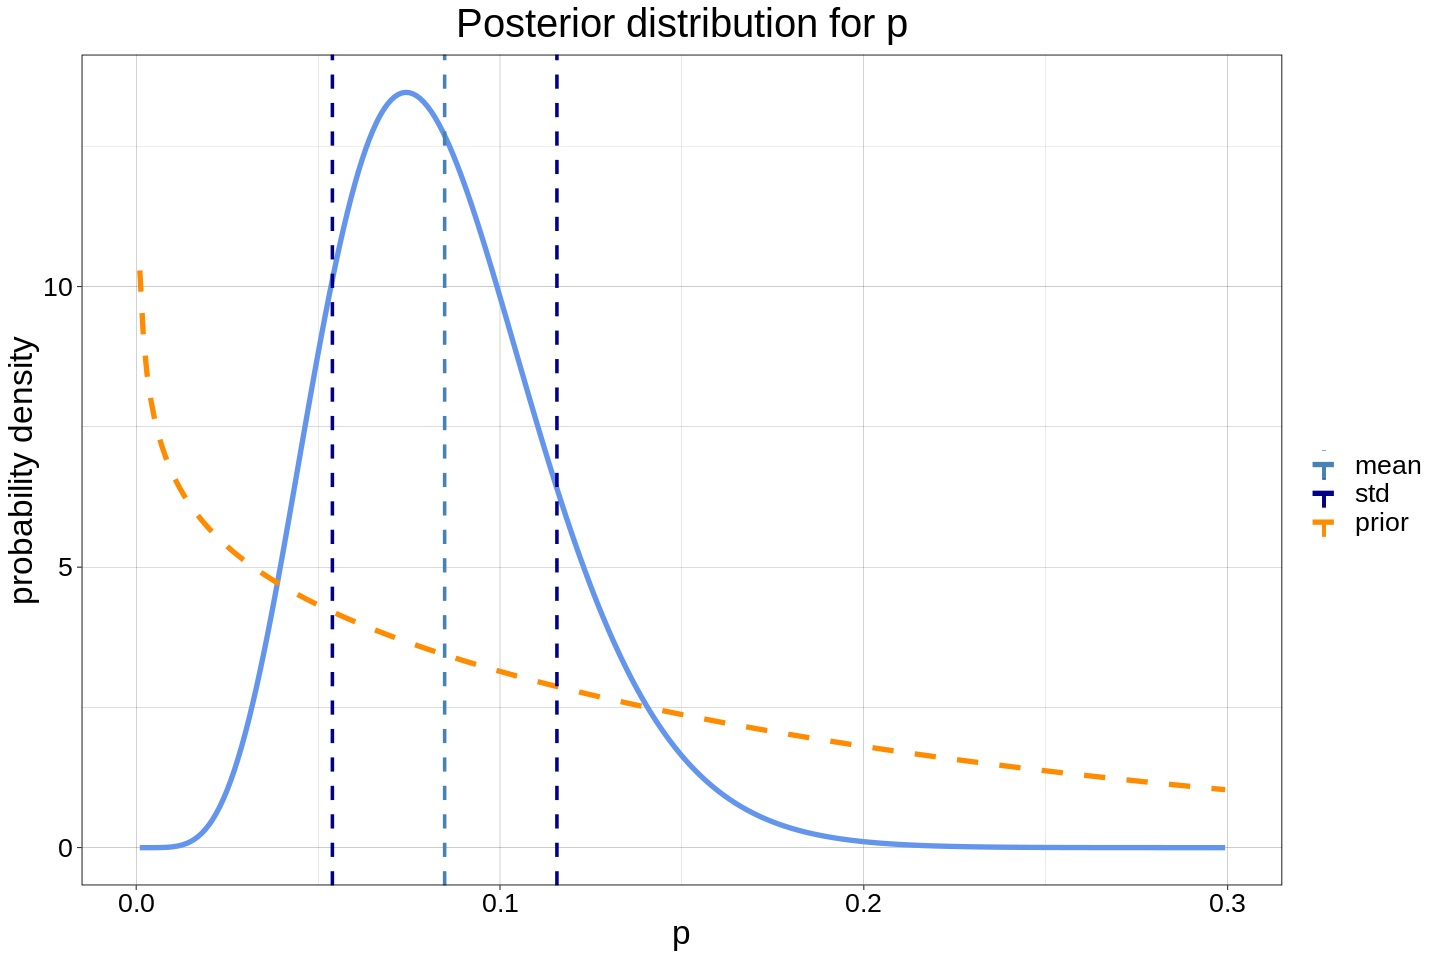

In [16]:
cols = c("mean"="steelblue", "std"="blue4", "prior"="darkorange")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.3], y=beta_posterior[p<0.3]), color="cornflowerblue", lwd=1.5) + 
     geom_line(aes(x=p[p<0.3], y=beta_prior[p<0.3], color="prior"), linetype="dashed", lwd=1.5) +                                                            
     theme(text = element_text(size=20)) +
     geom_vline(aes(xintercept=mean_post, color="mean"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_post-sqrt(var_post), color="std"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_post+sqrt(var_post), color="std"), lwd=1, linetype="dashed") +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +
     scale_color_manual(name="",
                         values=cols) +
     xlab("p") +
     xlim(c(0, 0.3))

plot_posterior

In [149]:
cat("Mean value of the posterior is", round(mean_post, 5), ", variance instead", round(var_post, 5))

Mean value of the posterior is 0.08479 , variance instead 0.00095

### Exercise 4

In [ ]:
library(rjags)

Recalling Ex 1, _Setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value 0.15 and standard deviation 0.14_, analyze these task using a MCMC with JAGS. (n=75, y=6)

-> _Solution_

First of all we have to define the JAGS model:

        model{
            # data likelihood
            y ~ dbinom(p, n)

            # uniform prior for p
            p ~ dbeta(alpha, beta)
        }


In [ ]:
# ex data
mu = 0.15
sd = 0.14
y  = 6
n  = 75

# compute prior parameters
alpha = ((1-mu)/sd^2-1/mu)*mu^2
beta  = alpha*(1/mu-1)

# define model data
data       = NULL

data$alpha = alpha
data$beta  = beta
data$y = y
data$n = n

# define model
model_file   = "ex4.bug"
jagsModel    = jags.model(model_file, data)

# run for a burn in period
update(jagsModel, n.iter=1000)

# generate MCMC samples
chain = coda.samples(jagsModel, c("p"), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0850193      0.0308666      0.0003087      0.0004243 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03519 0.06267 0.08147 0.10336 0.15714 



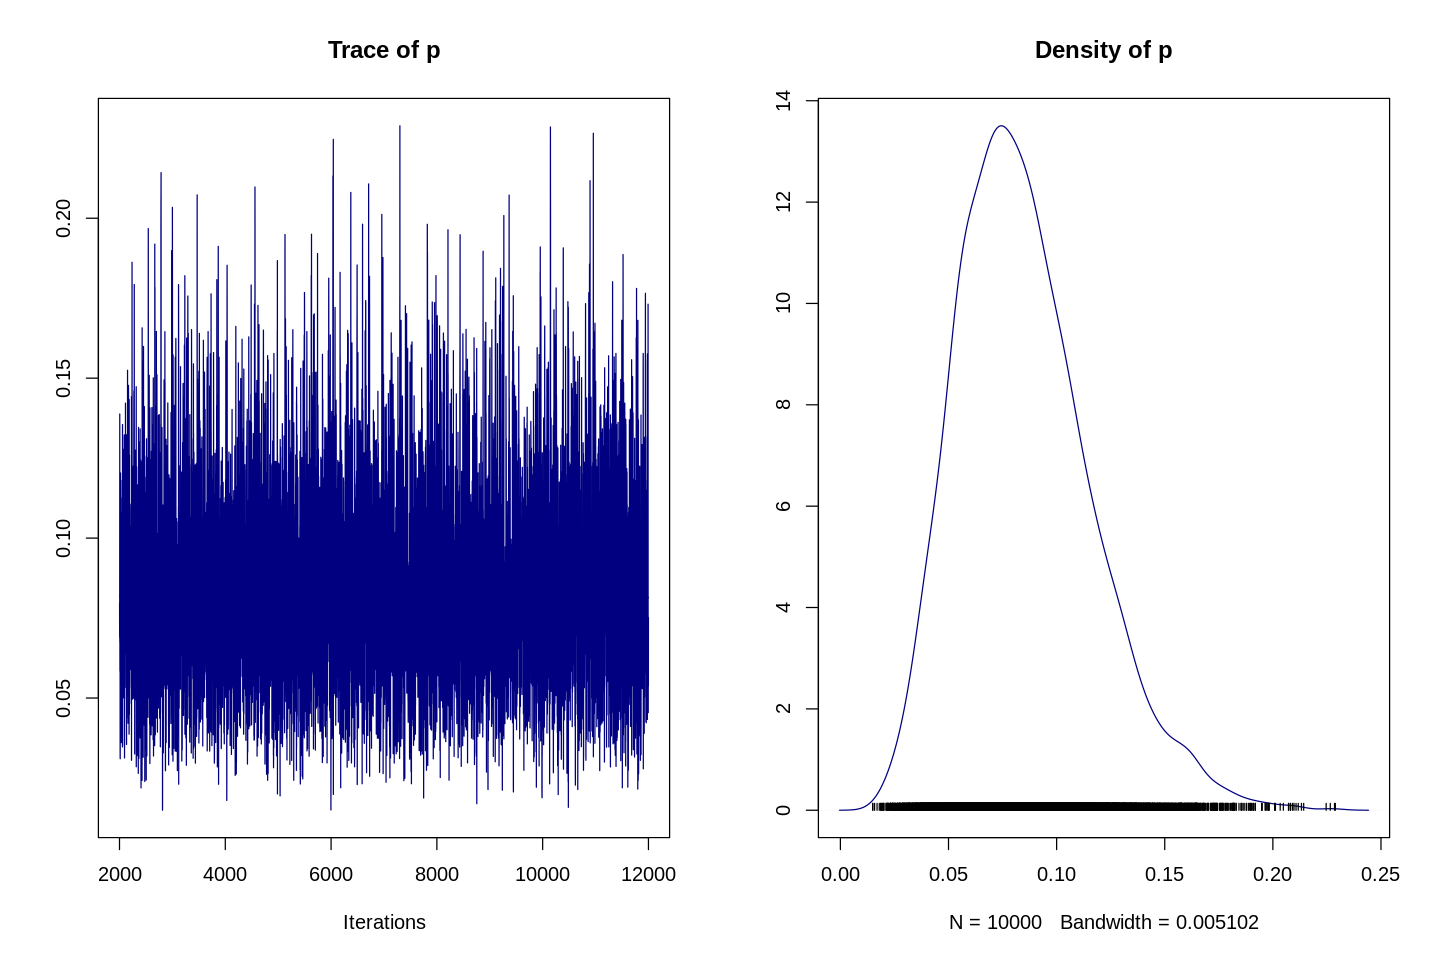

In [17]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain, col="navy")

In [20]:
# compare results with analytical solution
mean_post_jags = unname(summary(chain)$statistics["Mean"])
std_post_jags  = unname(summary(chain)$statistics["SD"])

cat("############################################# Analytical solution #############################################\n")
cat("Mean value of the posterior is", round(mean_post, 5), ", std instead", round(sqrt(var_post), 5), "\n\n")

cat("#############################################    Jags solution    #############################################\n")
cat("Mean value of the posterior is", round(mean_post_jags, 5), ", std instead", round(std_post_jags, 5), "\n\n")

############################################# Analytical solution #############################################
Mean value of the posterior is 0.08479 , std instead 0.03086 

#############################################    Jags solution    #############################################
Mean value of the posterior is 0.08502 , std instead 0.03087 



As we can notice results are very similar.

d)
- $H_0$ : the new method is not better than the old one, $p\ge 0.15$, where $p$ is the probability of failing to detect the desease in ill patients
- $H_1$ : $p < 0.15 $

In the Bayesian approach with significance 0.05 we have to evaluate the posterior probability of the null hypotesis, $P(p \ge 0.15 | y)$


In [150]:
p0 = 0.15
alpha = 0.05
p_H0_y = sum(beta_posterior[p>=p0]/n_points)
cat("P(H0|y) = ", round(p_H0_y, 4))

P(H0|y) =  0.0319

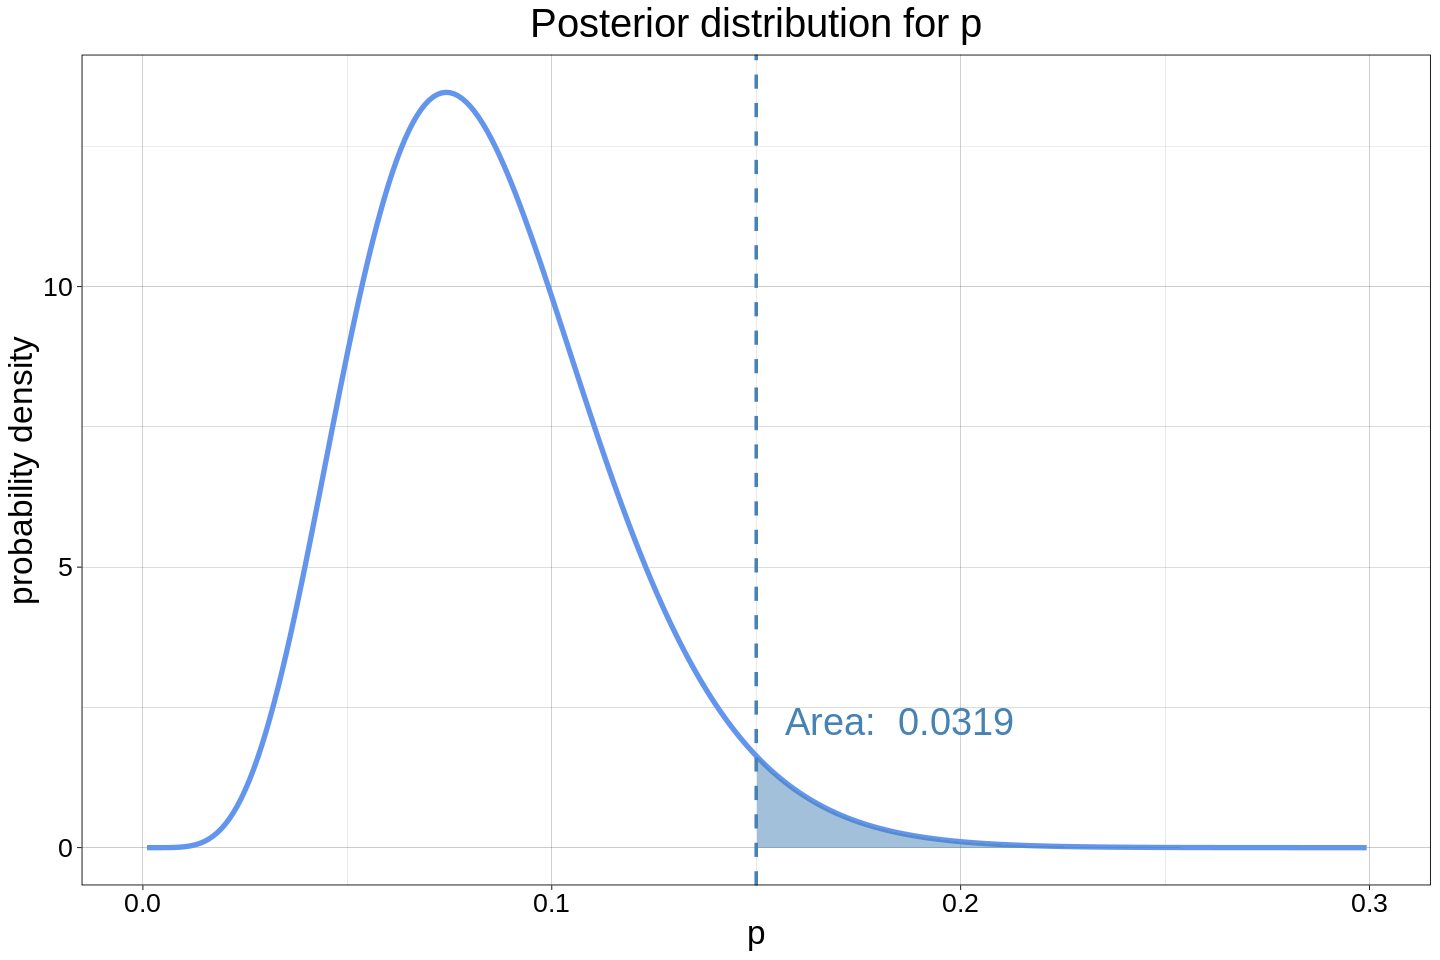

In [151]:
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.3], y=beta_posterior[p<0.3]), color="cornflowerblue", lwd=1.5) +                                                             
     theme(text = element_text(size=20)) +
     geom_ribbon(aes(x=p[p>=p0], y=beta_posterior[p>=p0], ymin=rep(0, n_points)[p>=p0], ymax=beta_posterior[p>=p0]), fill="steelblue", alpha=0.5) +
     geom_vline(aes(xintercept=p0), color="steelblue", lwd=1, linetype="dashed") +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +
     xlab("p") +
     xlim(c(0, 0.3)) +
     annotate(geom="text", x=p0+0.035, y=2.25, size=8, label=paste("Area: ", round(p_H0_y,4)),
              color="steelblue") 
plot_posterior

Given that $P(H_0|y)<\alpha$ we reject the null hypotesis at 0.05 level of significance

d) In the classical frequentis way we set the same null and alternative hypotesis as before, then, the null distribution of the test statistic is $\text{Binom}(y | n, p_0=0.15)$. We reject the null hypotesis at a 0.05 level of significance  if _pvalue_ $<\alpha$.

In [152]:
y_list = seq(0, 25, 1)
p_y_np = dbinom(y_list, n, 0.15)
cum_null = pbinom(y_list, n, 0.15)

p_value = sum(p_y_np[y_list<=6])
cat("p_value:", p_value)

p_value: 0.0543533

In [153]:
# alpha closest to 5%
low = qbinom(0.05, n, 0.15)
alpha = pbinom(low, n , 0.15)
cat("rejection region: y<=", low, "alpha:", alpha)

rejection region: y<= 6 alpha: 0.0543533

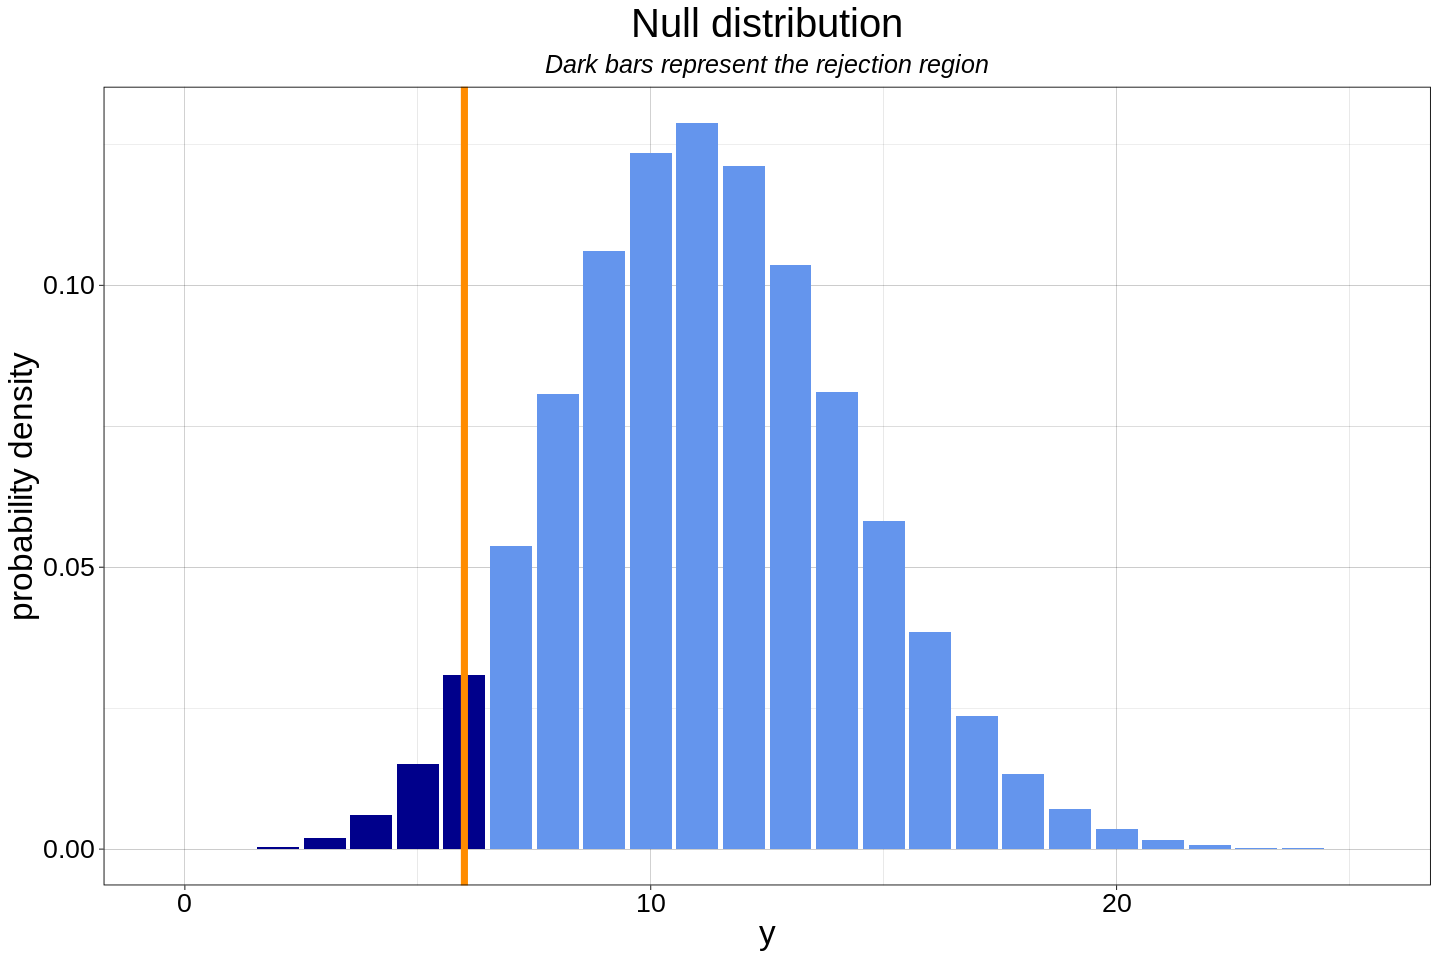

In [154]:
options(repr.plot.width=12, repr.plot.height=8) 
p = ggplot() +
    theme_linedraw() +
    theme(text=element_text(size=20), 
          plot.title=element_text(hjust = 0.5),
          plot.subtitle=element_text(hjust=0.5, size=15, face="italic")
          ) +
    ggtitle("Null distribution") +
    labs(subtitle="Dark bars represent the rejection region") +
    geom_bar(aes(x=y_list, y=p_y_np), 
             fill=ifelse(y_list>low, "cornflowerblue", "blue4"),
             stat="identity") +
    geom_vline(aes(xintercept=y), color="darkorange", lwd=2) +
    xlab("y") +
    ylab("probability density")
    
p

our observation lies right at the border of the rejection region, so we reject the null hypotesis

In [155]:
binom.test(x=6, n=75, p=0.15, alternative="less")


	Exact binomial test

data:  6 and 75
number of successes = 6, number of trials = 75, p-value = 0.05435
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1517971
sample estimates:
probability of success 
                  0.08 


## Exercise 2
Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the
Poisson distribution can be very useful in applied statistics when describing low-frequency events
in a large population. In a famous example he showed that the number of deaths by horse kick
among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different
corps:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-dvpl{border-color:inherit;text-align:right;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-dvpl"><span style="font-weight:bold">y death soldiers</span></th>
    <th class="tg-c3ow">0</th>
    <th class="tg-c3ow">1</th>
    <th class="tg-c3ow">2</th>
    <th class="tg-c3ow">3</th>
    <th class="tg-c3ow">4</th>
    <th class="tg-c3ow">&gt;=5</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-dvpl"><span style="font-weight:bold">n1 observations</span></td>
    <td class="tg-c3ow">109</td>
    <td class="tg-c3ow">65</td>
    <td class="tg-c3ow">22</td>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">0</td>
  </tr>
  <tr>
    <td class="tg-dvpl"><span style="font-weight:bold">n2 observations</span></td>
    <td class="tg-c3ow">144</td>
    <td class="tg-c3ow">91</td>
    <td class="tg-c3ow">32</td>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">2</td>
    <td class="tg-c3ow">0</td>
  </tr>
</tbody>
</table>

a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95%
credibility interval.

b) assuming now a Jeffreys’ prior,

$$
g(\lambda) \propto 1/\sqrt{\lambda}, \, \text{with} \, \lambda > 0
$$

compute and plot the posterior distribution for λ, the death rate over the measurement time.
Determine the posterior mean, median and variance, and compute the 95% credibility interval.




-> _Solution_

a) the posterior of a Poisson process with a unifom prior is a Gamma

In [21]:
n1 = c(109, 65, 22, 3, 1)
n2 = c(144, 91, 32, 11, 2)
y  = c(0, 1, 2, 3, 4)

n_points = 1000
mu_max = 5
mu_min = 0
mu = seq(mu_min, mu_max, length.out=n_points)

In [33]:
# n1 posterior
alpha_1  = sum(n1*y)+1
lambda_1 = sum(n1)
post_1 = dgamma(mu, alpha_1, lambda_1)
## mean, var, med 
mean_1 = alpha_1/lambda_1
var_1 = alpha_1/lambda_1^2
med_1 = mu[which(cumsum(post_1*(mu_max-mu_min)/n_points)>=0.5)][1]
## 95% credibility interval
low_1  = mu[cumsum(post_1*(mu_max-mu_min)/n_points)>0.025][1]
high_1 = mu[cumsum(post_1*(mu_max-mu_min)/n_points)>0.975][1]

# n2 posterior
alpha_2  = sum(n2*y)+1
lambda_2 = sum(n2)
post_2 = dgamma(mu, alpha_2, lambda_2)
## mean, var, med 
mean_2 = alpha_2/lambda_2
var_2 = alpha_2/lambda_2^2
med_2 = mu[which(cumsum(post_2*(mu_max-mu_min)/n_points)>=0.5)][1]
## 95% credibility interval
low_2  = mu[cumsum(post_2*(mu_max-mu_min)/n_points)>0.025][1]
high_2 = mu[cumsum(post_2*(mu_max-mu_min)/n_points)>0.975][1]

Warning message:
“Removed 850 row(s) containing missing values (geom_path).”
Warning message:
“Removed 850 row(s) containing missing values (geom_path).”


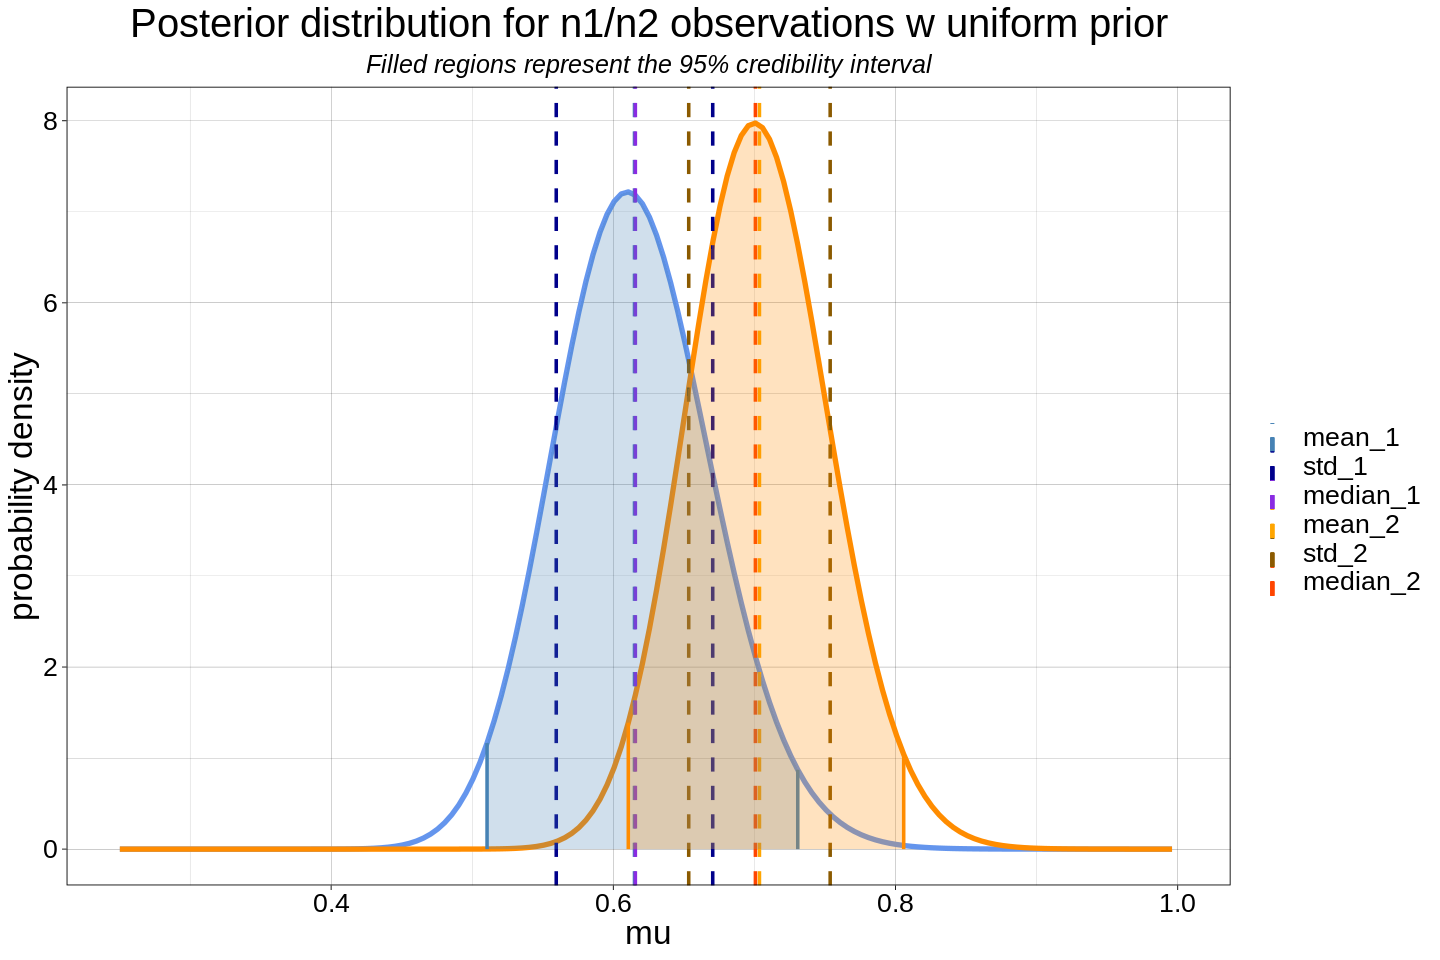

In [34]:
cols = c("mean_1"="steelblue", "std_1"="blue4", "median_1"="blueviolet",
         "mean_2"="orange1", "std_2"="orange4", "median_2"="orangered")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for n1/n2 observations w uniform prior") +
     theme(plot.title = element_text(hjust = 0.5))  +

     # plot posteriors                                           
     geom_line(aes(x=mu, y=post_1), color="cornflowerblue", lwd=1.5) +
     geom_line(aes(x=mu, y=post_2), color="darkorange", lwd=1.5) + 
     
     # plot mean, med, std
     geom_vline(aes(xintercept=mean_1, color="mean_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_1-sqrt(var_1), color="std_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_1+sqrt(var_1), color="std_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=med_1, color="median_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2, color="mean_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2-sqrt(var_2), color="std_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2+sqrt(var_2), color="std_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=med_2, color="median_2"), lwd=1, linetype="dashed") +

     # plot 95% credibility intervals
     geom_ribbon(aes(x=mu[which(between(mu, low_1, high_1))], 
                     ymax=post_1[which(between(mu, low_1, high_1))], 
                     ymin=rep(0, n_points)[which(between(mu, low_1, high_1))]),
                 fill="steelblue",
                 alpha=0.25) +  
     geom_segment(aes(x=high_1, xend=high_1, y=0, yend=post_1[which(mu>=high_1)][1]),
                  color="steelblue",
                  lwd=1) +
     geom_segment(aes(x=low_1, xend=low_1, y=0, yend=post_1[which(mu>=low_1)][1]),
                  color="steelblue",
                  lwd=1) + 
     geom_ribbon(aes(x=mu[which(between(mu, low_2, high_2))], 
                     ymax=post_2[which(between(mu, low_2, high_2))], 
                     ymin=rep(0, n_points)[which(between(mu, low_2, high_2))]),
                 fill="darkorange",
                 alpha=0.25) +  
     geom_segment(aes(x=high_2, xend=high_2, y=0, yend=post_2[which(mu>=high_2)][1]),
                  color="darkorange",
                  lwd=1) +
     geom_segment(aes(x=low_2, xend=low_2, y=0, yend=post_2[which(mu>=low_2)][1]),
                  color="darkorange",
                  lwd=1) + 

     # labels and limits
     labs(subtitle="Filled regions represent the 95% credibility interval") +
     theme(plot.title = element_text(hjust = 0.5), 
           plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
     ylab("probability density") +
     scale_color_manual(name="",
                         values=cols) +
     xlab("mu") +
     xlim(c(0.25, 1)) 

suppressWarnings(plot_posterior)

In [35]:
cat("###################################### n1 ######################################\n")
cat(" mean:", round(mean_1, 4), "variance:", round(var_1, 4), "median:", round(med_1, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1, 3), "high:", round(high_1, 3)," \n")
cat("###################################### n2 ######################################\n")
cat(" mean:", round(mean_2, 4), "variance:", round(var_2, 4), "median:", round(med_2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2, 3), "high:", round(high_2, 3)," \n")

###################################### n1 ######################################
 mean: 0.615 variance: 0.0031 median: 0.6156
 Bounds for a 95% credibility interval:
	 low: 0.511 high: 0.731  
###################################### n2 ######################################
 mean: 0.7036 variance: 0.0025 median: 0.7007
 Bounds for a 95% credibility interval:
	 low: 0.611 high: 0.806  


### Exercise 5.1
Redo this analysis with JAGS
Uniform prior
First of all we have to define the JAGS model:

        model{
            # data likelihood
            for( i in 1:lenght(y) ){
                y[i] ~ dpois(p)
            }

            # uniform prior for p
            p ~ dunif(min, max)
        }

In [28]:
# define model data1
data1       = NULL

data1$min  = mu_min
data1$max  = mu_max
data1$y = rep(y, n1)

# define model
model_file   = "ex5_1.bug"
jagsModel1    = jags.model(model_file, data1)

# run for a burn in period
update(jagsModel1, n.iter=1000)

# generate MCMC samples
chain1 = coda.samples(jagsModel1, c("p"), n.iter=10000)
print(summary(chain1))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 1
   Total graph size: 203

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6153494      0.0566501      0.0005665      0.0007389 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5093 0.5759 0.6135 0.6529 0.7298 



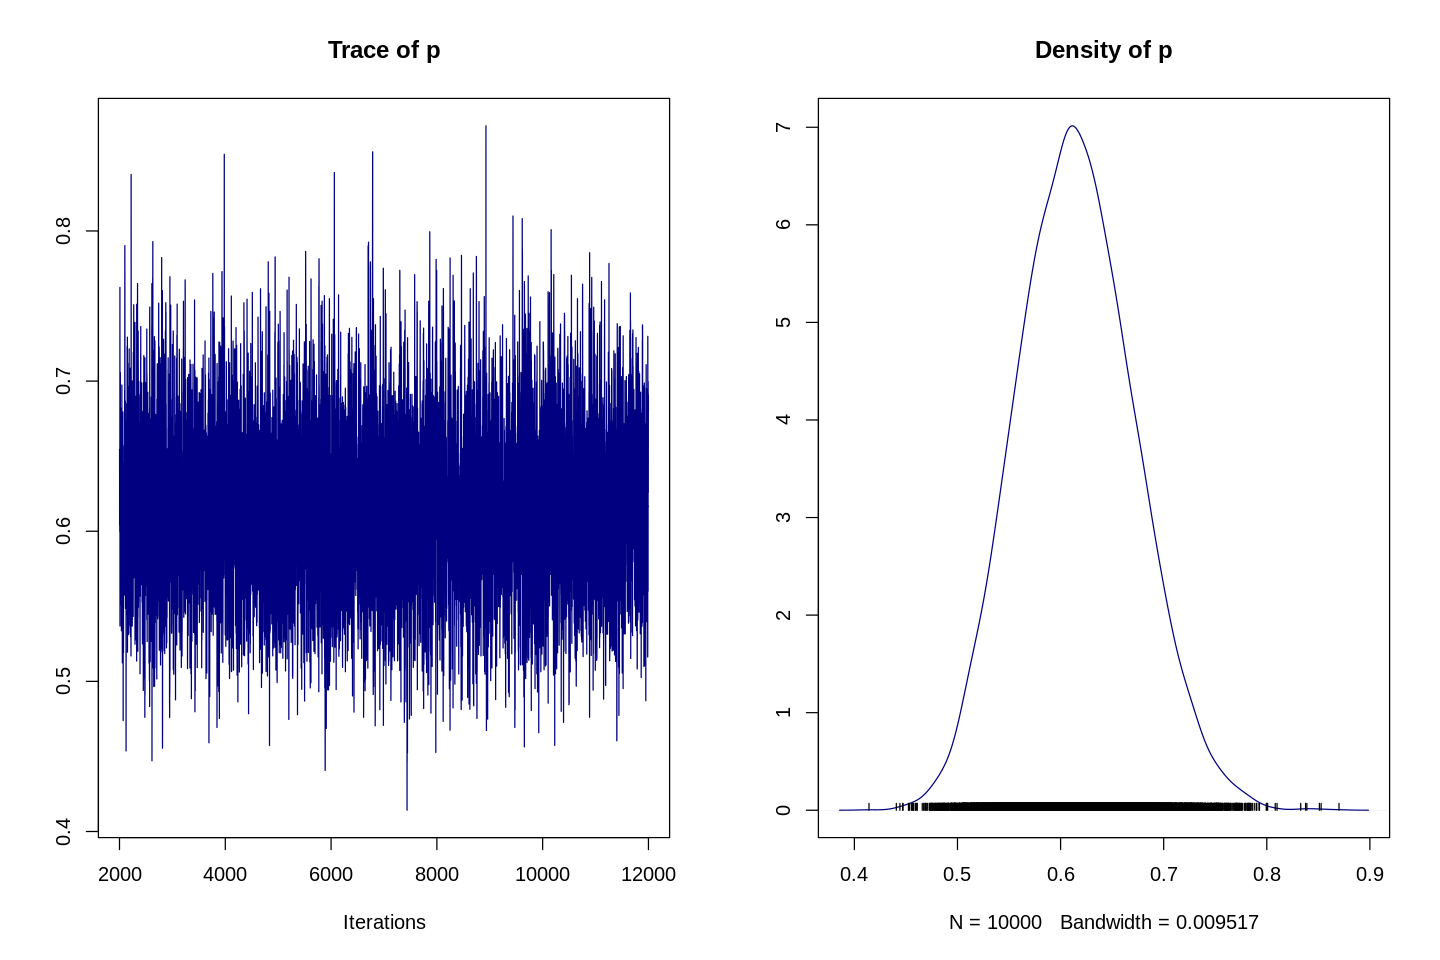

In [29]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain1, col="navy")

In [30]:
# define model data2
data2       = NULL

data2$min  = mu_min
data2$max  = mu_max
data2$y = rep(y, n2)

# define model
model_file   = "ex5_1.bug"
jagsModel2    = jags.model(model_file, data2)

# run for a burn in period
update(jagsModel2, n.iter=1000)

# generate MCMC samples
chain2 = coda.samples(jagsModel2, c("p"), n.iter=10000)
print(summary(chain2))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 1
   Total graph size: 283

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7031317      0.0502621      0.0005026      0.0006530 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6074 0.6685 0.7025 0.7363 0.8042 



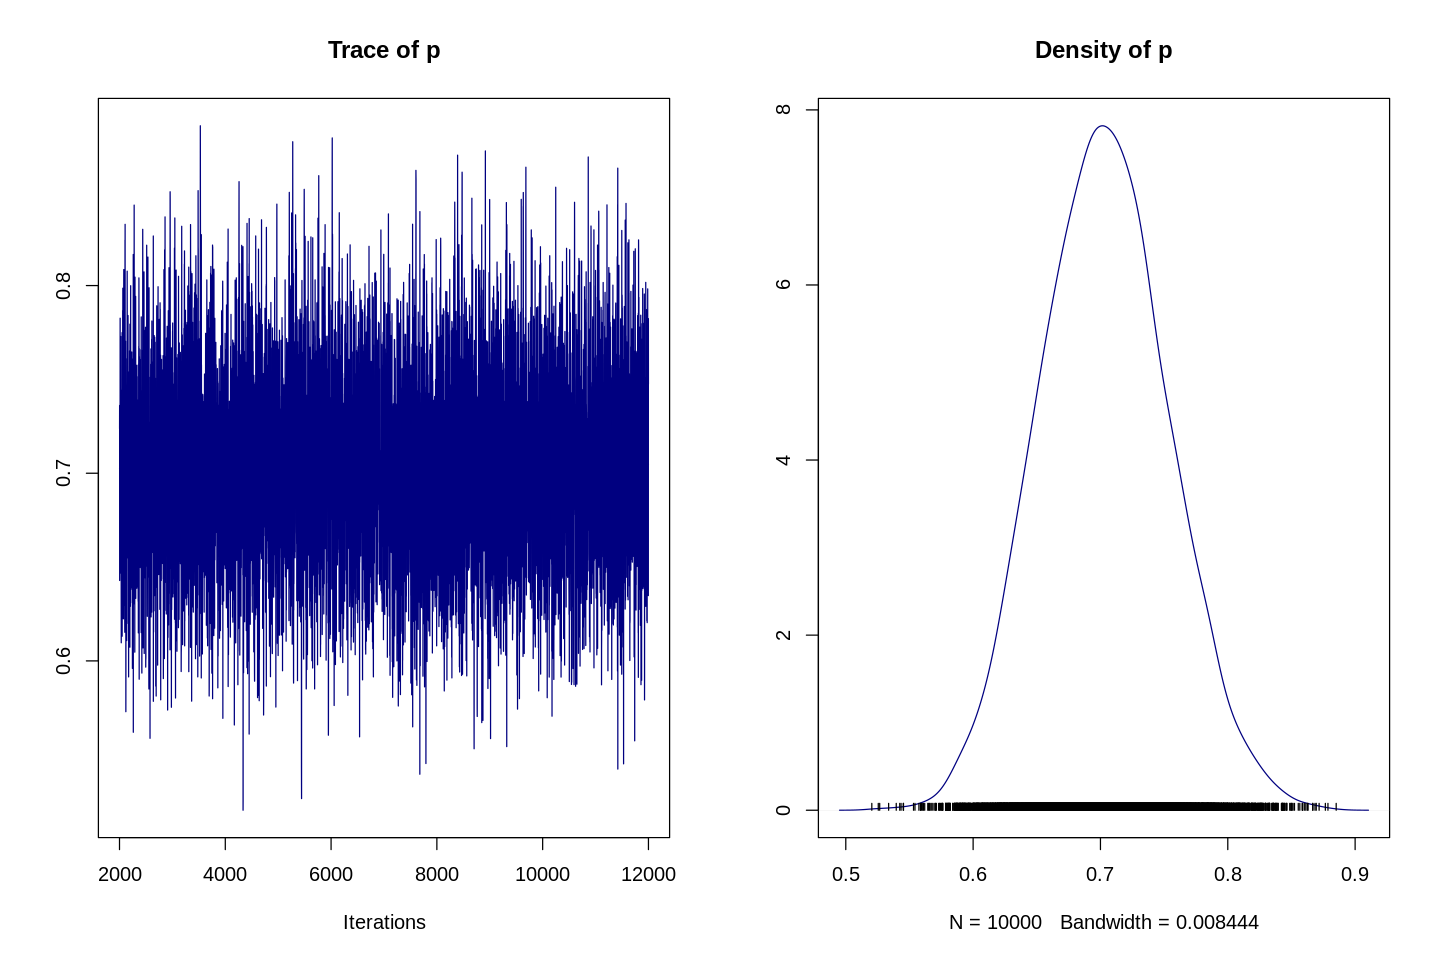

In [31]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain2, col="navy")

In [37]:
cat("################################## analytical ##################################\n\n")
cat(" n1 \n")
cat(" mean:", round(mean_1, 4), "variance:", round(var_1, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1, 3), "high:", round(high_1, 3)," \n")
cat(" n2 \n")
cat(" mean:", round(mean_2, 4), "variance:", round(var_2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2, 3), "high:", round(high_2, 3)," \n\n")

mean_1_jags = unname(summary(chain1)$statistics["Mean"])
std_1_jags  = unname(summary(chain1)$statistics["SD"])
high_1_jags = unname(summary(chain1)$quantiles["97.5%"])
low_1_jags = unname(summary(chain1)$quantiles["2.5%"])

mean_2_jags = unname(summary(chain2)$statistics["Mean"])
std_2_jags  = unname(summary(chain2)$statistics["SD"])
high_2_jags = unname(summary(chain2)$quantiles["97.5%"])
low_2_jags = unname(summary(chain2)$quantiles["2.5%"])


cat("####################################  jags  ####################################\n")
cat(" n1 \n")
cat(" mean:", round(mean_1_jags, 4), "variance:", round(std_1_jags^2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1_jags, 3), "high:", round(high_1_jags, 3)," \n")
cat("n2 \n")
cat(" mean:", round(mean_2_jags, 4), "variance:", round(std_2_jags^2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2_jags, 3), "high:", round(high_2_jags, 3)," \n")

################################## analytical ##################################

 n1 
 mean: 0.615 variance: 0.0031
 Bounds for a 95% credibility interval:
	 low: 0.511 high: 0.731  
 n2 
 mean: 0.7036 variance: 0.0025
 Bounds for a 95% credibility interval:
	 low: 0.611 high: 0.806  

####################################  jags  ####################################
 n1 
 mean: 0.6153 variance: 0.0032
 Bounds for a 95% credibility interval:
	 low: 0.509 high: 0.73  
n2 
 mean: 0.7031 variance: 0.0025
 Bounds for a 95% credibility interval:
	 low: 0.607 high: 0.804  


c) with a Jeffrey's prior we get

In [46]:
# n1 posterior
alpha_1  = sum(n1*y)+1/2
lambda_1 = sum(n1)
post_1 = dgamma(mu, alpha_1, lambda_1)
## mean, var, med 
mean_1 = alpha_1/lambda_1
var_1 = alpha_1/lambda_1^2
med_1 = mu[which(cumsum(post_1*(mu_max-mu_min)/n_points)>=0.5)][1]
## 95% credibility interval
low_1  = mu[cumsum(post_1*(mu_max-mu_min)/n_points)>0.025][1]
high_1 = mu[cumsum(post_1*(mu_max-mu_min)/n_points)>0.975][1]

# n2 posterior
alpha_2  = sum(n2*y)+1/2
lambda_2 = sum(n2)
post_2 = dgamma(mu, alpha_2, lambda_2)
## mean, var, med 
mean_2 = alpha_2/lambda_2
var_2 = alpha_2/lambda_2^2
med_2 = mu[which(cumsum(post_2*(mu_max-mu_min)/n_points)>=0.5)][1]
## 95% credibility interval
low_2  = mu[cumsum(post_2*(mu_max-mu_min)/n_points)>0.025][1]
high_2 = mu[cumsum(post_2*(mu_max-mu_min)/n_points)>0.975][1]

Warning message:
“Removed 850 row(s) containing missing values (geom_path).”
Warning message:
“Removed 850 row(s) containing missing values (geom_path).”


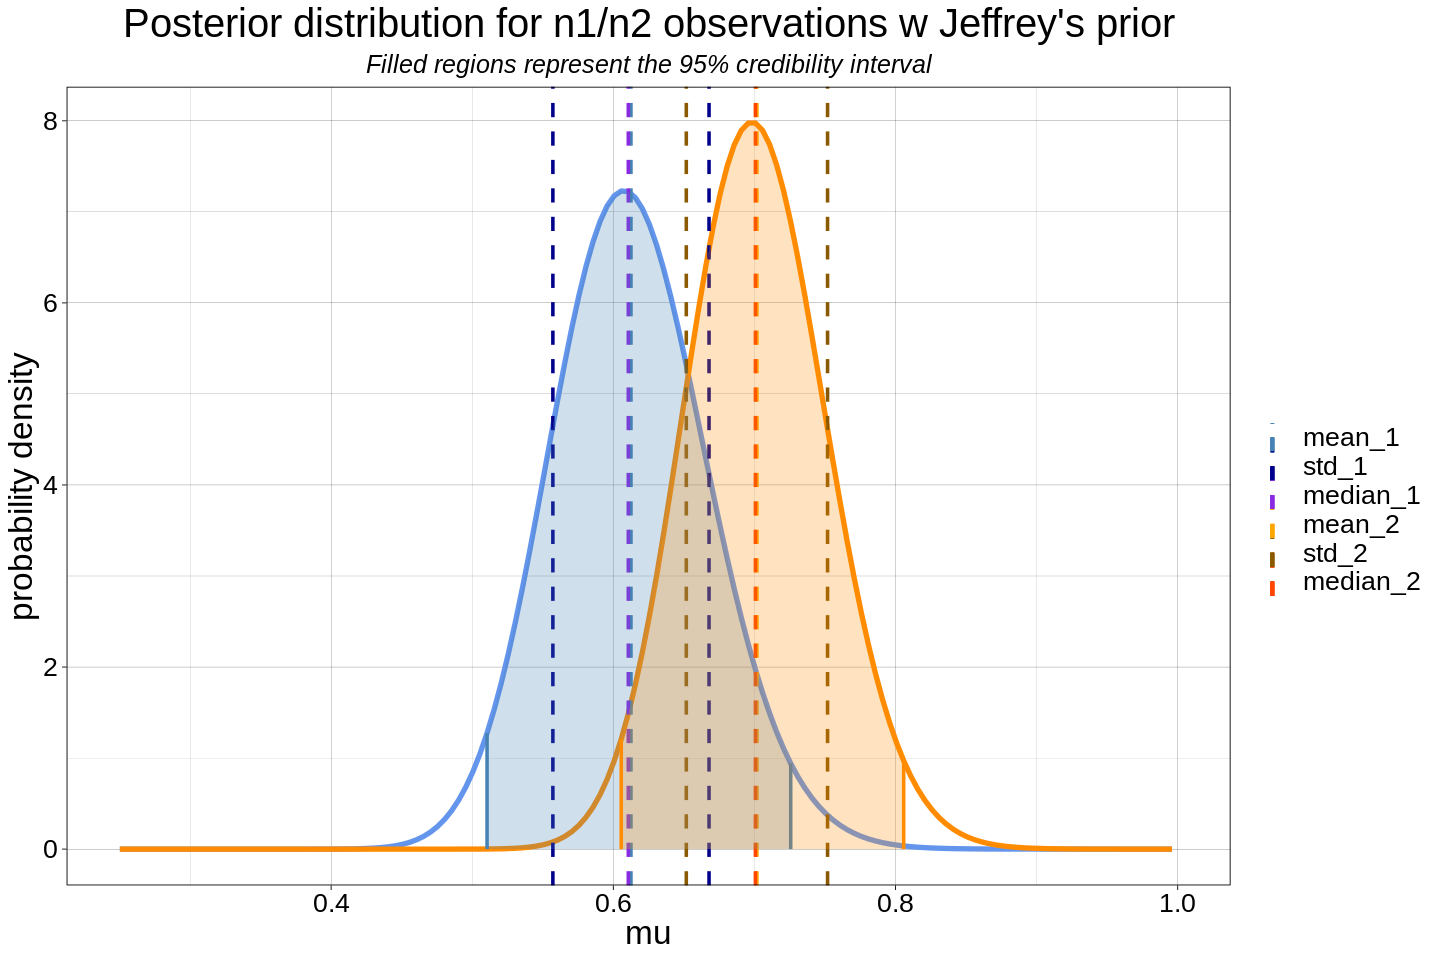

In [47]:
cols = c("mean_1"="steelblue", "std_1"="blue4", "median_1"="blueviolet",
         "mean_2"="orange1", "std_2"="orange4", "median_2"="orangered")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for n1/n2 observations w Jeffrey's prior") +
     theme(plot.title = element_text(hjust = 0.5))  +

     # plot posteriors                                           
     geom_line(aes(x=mu, y=post_1), color="cornflowerblue", lwd=1.5) +
     geom_line(aes(x=mu, y=post_2), color="darkorange", lwd=1.5) + 
     
     # plot mean, med, std
     geom_vline(aes(xintercept=mean_1, color="mean_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_1-sqrt(var_1), color="std_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_1+sqrt(var_1), color="std_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=med_1, color="median_1"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2, color="mean_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2-sqrt(var_2), color="std_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=mean_2+sqrt(var_2), color="std_2"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=med_2, color="median_2"), lwd=1, linetype="dashed") +

     # plot 95% credibility intervals
     geom_ribbon(aes(x=mu[which(between(mu, low_1, high_1))], 
                     ymax=post_1[which(between(mu, low_1, high_1))], 
                     ymin=rep(0, n_points)[which(between(mu, low_1, high_1))]),
                 fill="steelblue",
                 alpha=0.25) +  
     geom_segment(aes(x=high_1, xend=high_1, y=0, yend=post_1[which(mu>=high_1)][1]),
                  color="steelblue",
                  lwd=1) +
     geom_segment(aes(x=low_1, xend=low_1, y=0, yend=post_1[which(mu>=low_1)][1]),
                  color="steelblue",
                  lwd=1) + 
     geom_ribbon(aes(x=mu[which(between(mu, low_2, high_2))], 
                     ymax=post_2[which(between(mu, low_2, high_2))], 
                     ymin=rep(0, n_points)[which(between(mu, low_2, high_2))]),
                 fill="darkorange",
                 alpha=0.25) +  
     geom_segment(aes(x=high_2, xend=high_2, y=0, yend=post_2[which(mu>=high_2)][1]),
                  color="darkorange",
                  lwd=1) +
     geom_segment(aes(x=low_2, xend=low_2, y=0, yend=post_2[which(mu>=low_2)][1]),
                  color="darkorange",
                  lwd=1) + 

     # labels and limits
     labs(subtitle="Filled regions represent the 95% credibility interval") +
     theme(plot.title = element_text(hjust = 0.5), 
           plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
     ylab("probability density") +
     scale_color_manual(name="",
                         values=cols) +
     xlab("mu") +
     xlim(c(0.25, 1)) 

suppressWarnings(plot_posterior)

In [48]:
cat("###################################### n1 ######################################\n")
cat(" mean:", round(mean_1, 4), "variance:", round(var_1, 4), "median:", round(med_1, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1, 3), "high:", round(high_1, 3)," \n")
cat("###################################### n2 ######################################\n")
cat(" mean:", round(mean_2, 4), "variance:", round(var_2, 4), "median:", round(med_2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2, 3), "high:", round(high_2, 3)," \n")

###################################### n1 ######################################
 mean: 0.6125 variance: 0.0031 median: 0.6106
 Bounds for a 95% credibility interval:
	 low: 0.511 high: 0.726  
###################################### n2 ######################################
 mean: 0.7018 variance: 0.0025 median: 0.7007
 Bounds for a 95% credibility interval:
	 low: 0.606 high: 0.806  


### Exercise 5.2
Redo this analysis with JAGS
Uniform prior
First of all we have to define the JAGS model:

        model{
            # data likelihood
            for( i in 1:length(y) ){
                y[i] ~ dpois(p)
            }

            # jeffreys prior for p
            p ~ dgamma(alpha, lambda)
        }

In [41]:
# define model data1
data1       = NULL

data1$alpha   = 0.5
data1$lambda  = 0.000000001 # putting 0 gives error
data1$y = rep(y, n1)

# define model
model_file   = "ex5_2.bug"
jagsModel1    = jags.model(model_file, data1)

# run for a burn in period
update(jagsModel1, n.iter=1000)

# generate MCMC samples
chain1 = coda.samples(jagsModel1, c("p"), n.iter=10000)
print(summary(chain1))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 1
   Total graph size: 203

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      0.611918       0.054897       0.000549       0.000561 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5108 0.5731 0.6098 0.6481 0.7247 



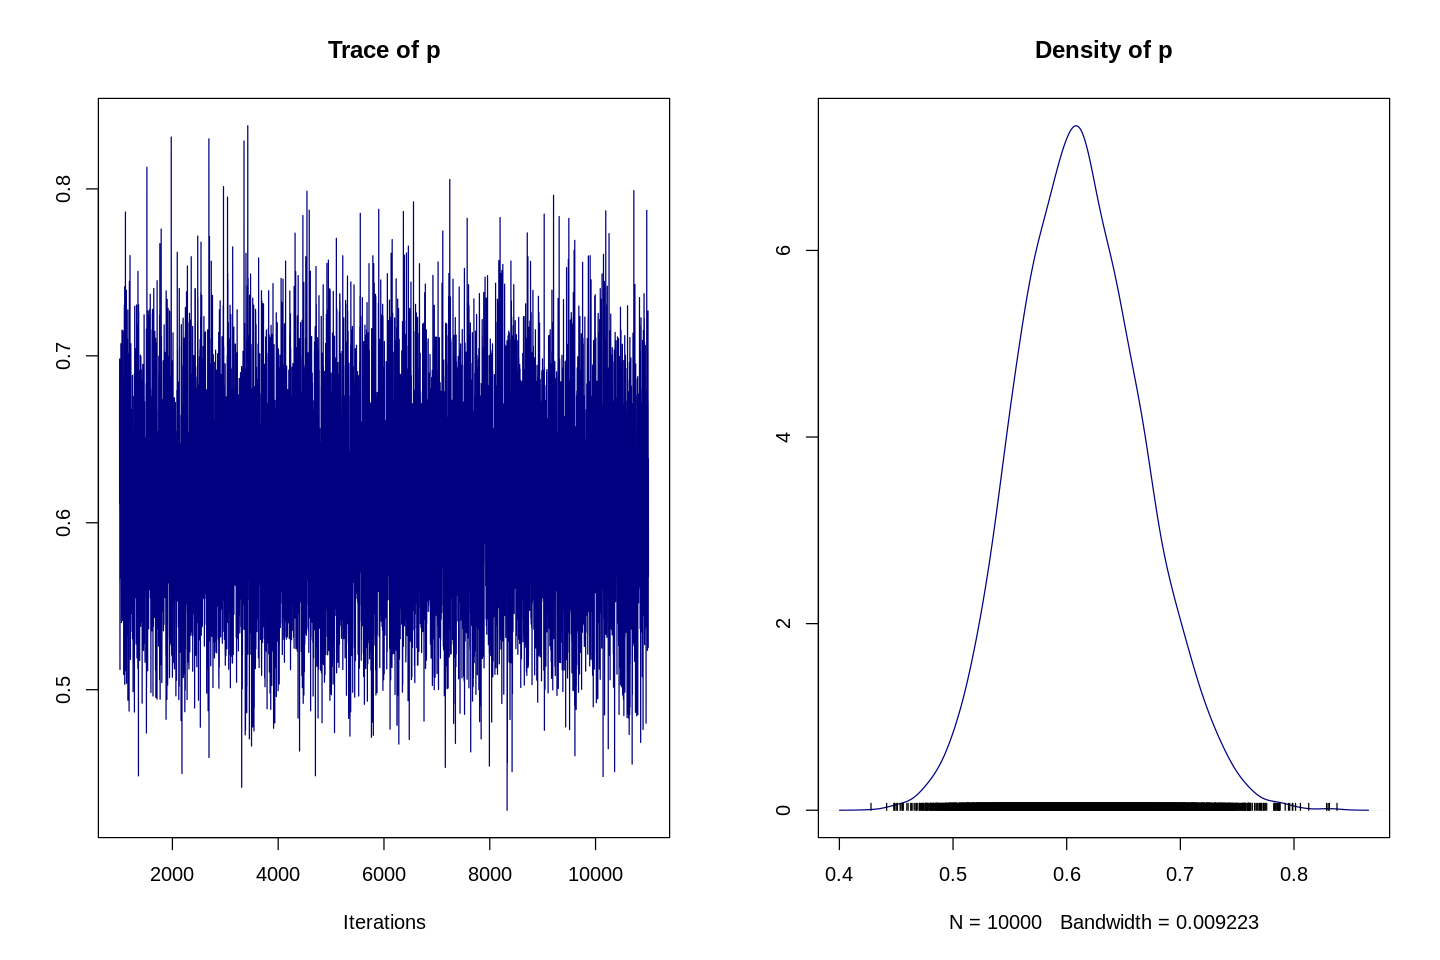

In [42]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain1, col="navy")

In [44]:
# define model data2
data2       = NULL

data2$alpha   = 0.5
data2$lambda  = 0.000000001 # putting 0 gives error
data2$y = rep(y, n2)

# define model
model_file   = "ex5_2.bug"
jagsModel2    = jags.model(model_file, data2)

# run for a burn in period
update(jagsModel2, n.iter=1000)

# generate MCMC samples
chain2 = coda.samples(jagsModel2, c("p"), n.iter=10000)
print(summary(chain2))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 1
   Total graph size: 283

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7016744      0.0502919      0.0005029      0.0005029 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6071 0.6671 0.7006 0.7344 0.8035 



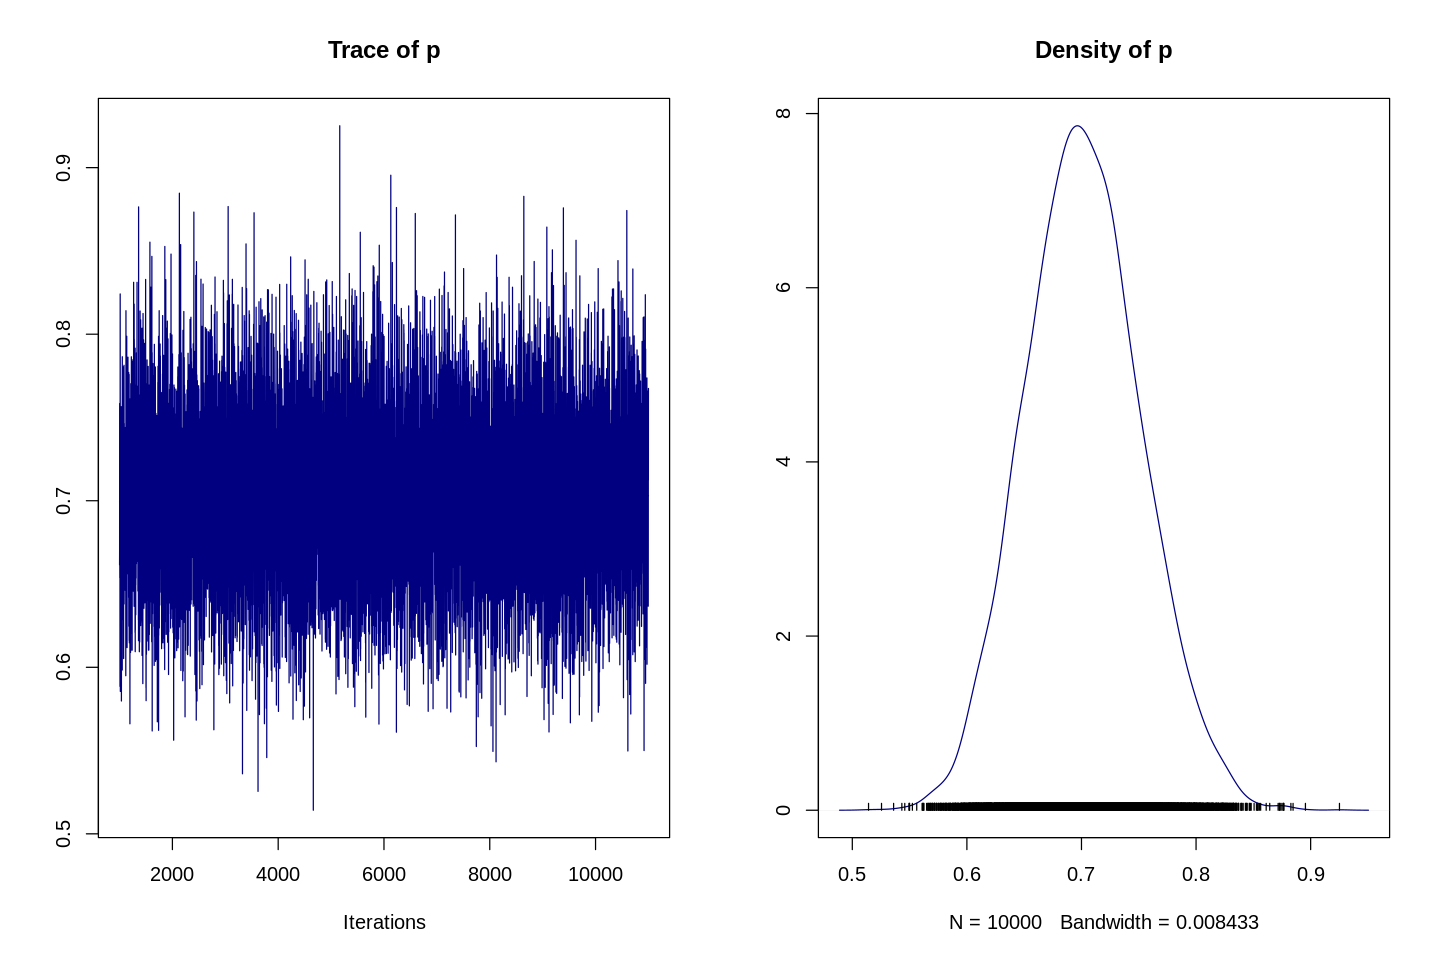

In [45]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain2, col="navy")

In [49]:
cat("################################## analytical ##################################\n\n")
cat(" n1 \n")
cat(" mean:", round(mean_1, 4), "variance:", round(var_1, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1, 3), "high:", round(high_1, 3)," \n")
cat(" n2 \n")
cat(" mean:", round(mean_2, 4), "variance:", round(var_2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2, 3), "high:", round(high_2, 3)," \n\n")

mean_1_jags = unname(summary(chain1)$statistics["Mean"])
std_1_jags  = unname(summary(chain1)$statistics["SD"])
high_1_jags = unname(summary(chain1)$quantiles["97.5%"])
low_1_jags = unname(summary(chain1)$quantiles["2.5%"])

mean_2_jags = unname(summary(chain2)$statistics["Mean"])
std_2_jags  = unname(summary(chain2)$statistics["SD"])
high_2_jags = unname(summary(chain2)$quantiles["97.5%"])
low_2_jags = unname(summary(chain2)$quantiles["2.5%"])


cat("####################################  jags  ####################################\n")
cat(" n1 \n")
cat(" mean:", round(mean_1_jags, 4), "variance:", round(std_1_jags^2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_1_jags, 3), "high:", round(high_1_jags, 3)," \n")
cat("n2 \n")
cat(" mean:", round(mean_2_jags, 4), "variance:", round(std_2_jags^2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_2_jags, 3), "high:", round(high_2_jags, 3)," \n")

################################## analytical ##################################

 n1 
 mean: 0.6125 variance: 0.0031
 Bounds for a 95% credibility interval:
	 low: 0.511 high: 0.726  
 n2 
 mean: 0.7018 variance: 0.0025
 Bounds for a 95% credibility interval:
	 low: 0.606 high: 0.806  

####################################  jags  ####################################
 n1 
 mean: 0.6119 variance: 0.003
 Bounds for a 95% credibility interval:
	 low: 0.511 high: 0.725  
n2 
 mean: 0.7017 variance: 0.0025
 Bounds for a 95% credibility interval:
	 low: 0.607 high: 0.803  


## Exercise 3
A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level. Indicating with p the probability that a sample of water taken from the stream has a high bacter
X level,

a) find the frequentist estimator for $p$

b) using a $\text{Beta}(1, 10)$ prior for $p$, calculate and plot the posterior distribution $P(p|y)$

c) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval

d) test the hypotesis

$$
H_0 : p = 0.1 \, \text{versus} \,  H_1 : p \neq 0.1
$$

at 5% level of significance with both the frequentist and bayesian approach

-> a new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter X level

e) find the frequentist estimator for $p$

f) find a bayesian estimator for $p$, assuming both a $\text{Beta}(1, 10) $ prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.

g) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval

h) test the hypotesis

$$
H_0 : p = 0.1 \, \text{versus} \,  H_1 : p \neq 0.1
$$

at 5% level of significance with both the frequentist and bayesian approach


-> _Solution_

a) we are interested in the number of successes in n trials so we are talking about a bernoulli process, the frequentist unbiased estimator for the binomial distribution is $p = y/n_\text{samples} = 11/116  = 0.095 \%$

b) the conjugate distribution of a bernoulli process is the beta distribution so, starting with a $\text{Beta}(1, 10)$ prior the posterior will be a $\text{Beta}(1+y=12, 10+n_\text{samples}-y=115)$

In [66]:
n = 116
y = 11

n_points = 1000
p = seq(0, 1, length.out = n_points)


#prior
alpha = 1
beta  = 10
beta_prior = dbeta(p, alpha, beta)

# posterior
alpha_p = alpha+y
beta_p  = beta+n-y
beta_posterior = dbeta(p, alpha_p, beta_p)

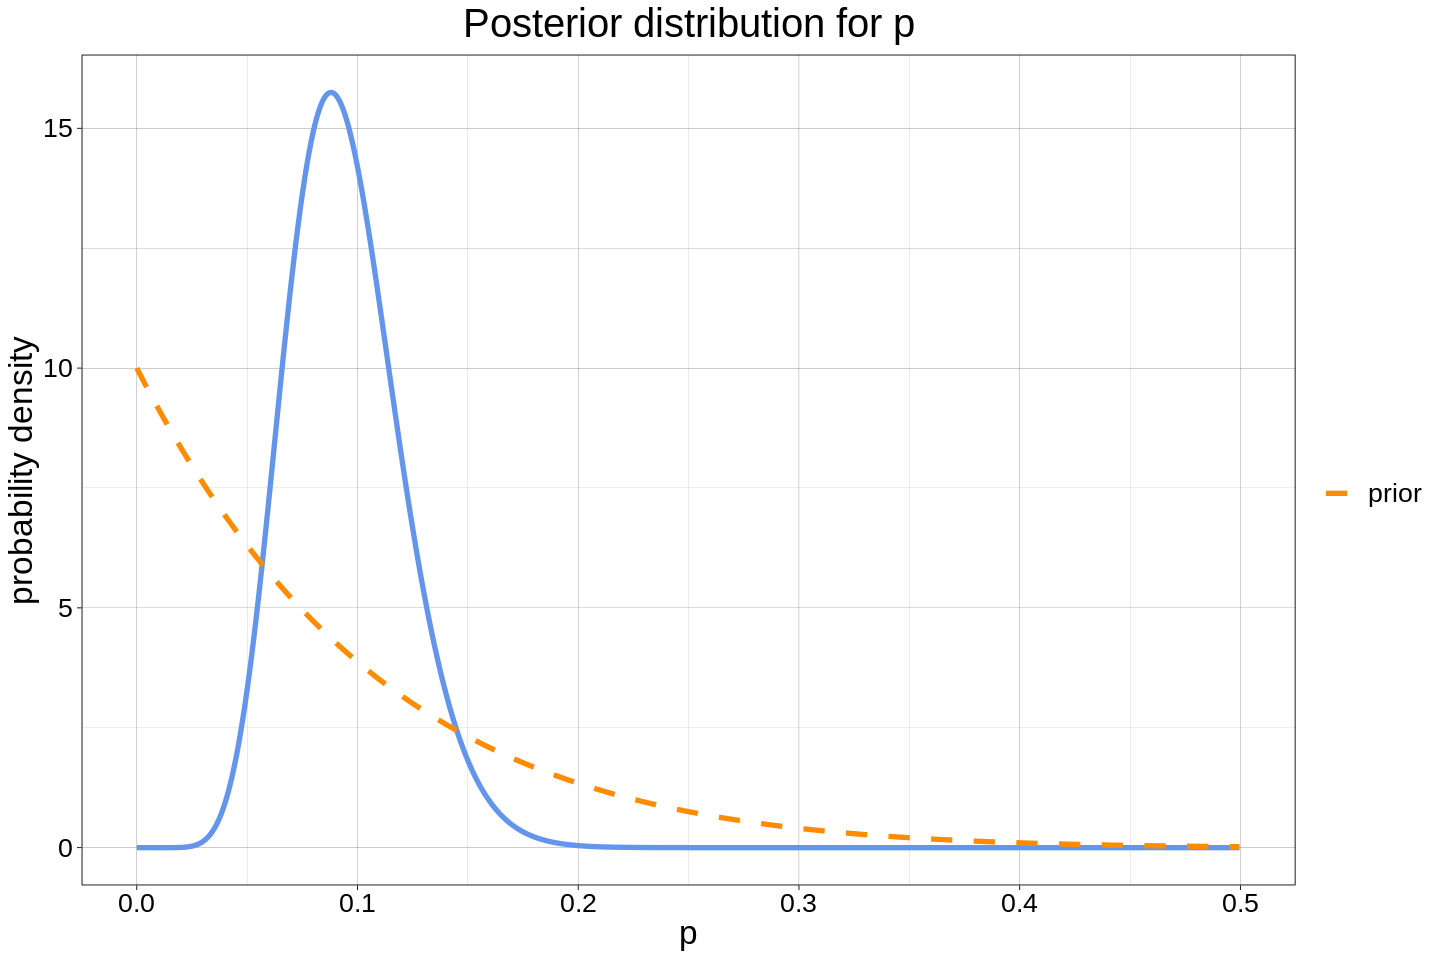

In [67]:
cols = c("prior"="darkorange")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.5], y=beta_posterior[p<0.5]), color="cornflowerblue", lwd=1.5) + 
     geom_line(aes(x=p[p<0.5], y=beta_prior[p<0.5], color="prior"), linetype="dashed", lwd=1.5) +                                                            
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +
     scale_color_manual(name="",
                         values=cols) +
     xlab("p") +
     xlim(c(0, 0.5))

plot_posterior

c)

We take as bayesian estimator the mode of the posterior distribution

In [68]:
p_B   = alpha_p/(alpha_p+beta_p)
var_B = alpha_p*beta_p/((alpha_p+beta_p)^2*(alpha_p+beta_p+1))
post_high = p[cumsum(beta_posterior/n_points)>0.975][1]
post_low  = p[cumsum(beta_posterior/n_points)>0.025][1]
cat("###################################### beta prior ######################################\n")
cat(" bayesian estimator = ", round(p[which.max(beta_posterior)], 3),"\n")
cat(" mean:", round(p_B, 4), "variance:", round(var_B, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(post_low, 3), "high:", round(post_high, 3)," \n")

###################################### beta prior ######################################
 bayesian estimator =  0.088 
 mean: 0.0945 variance: 7e-04
 Bounds for a 95% credibility interval:
	 low: 0.05 high: 0.151  


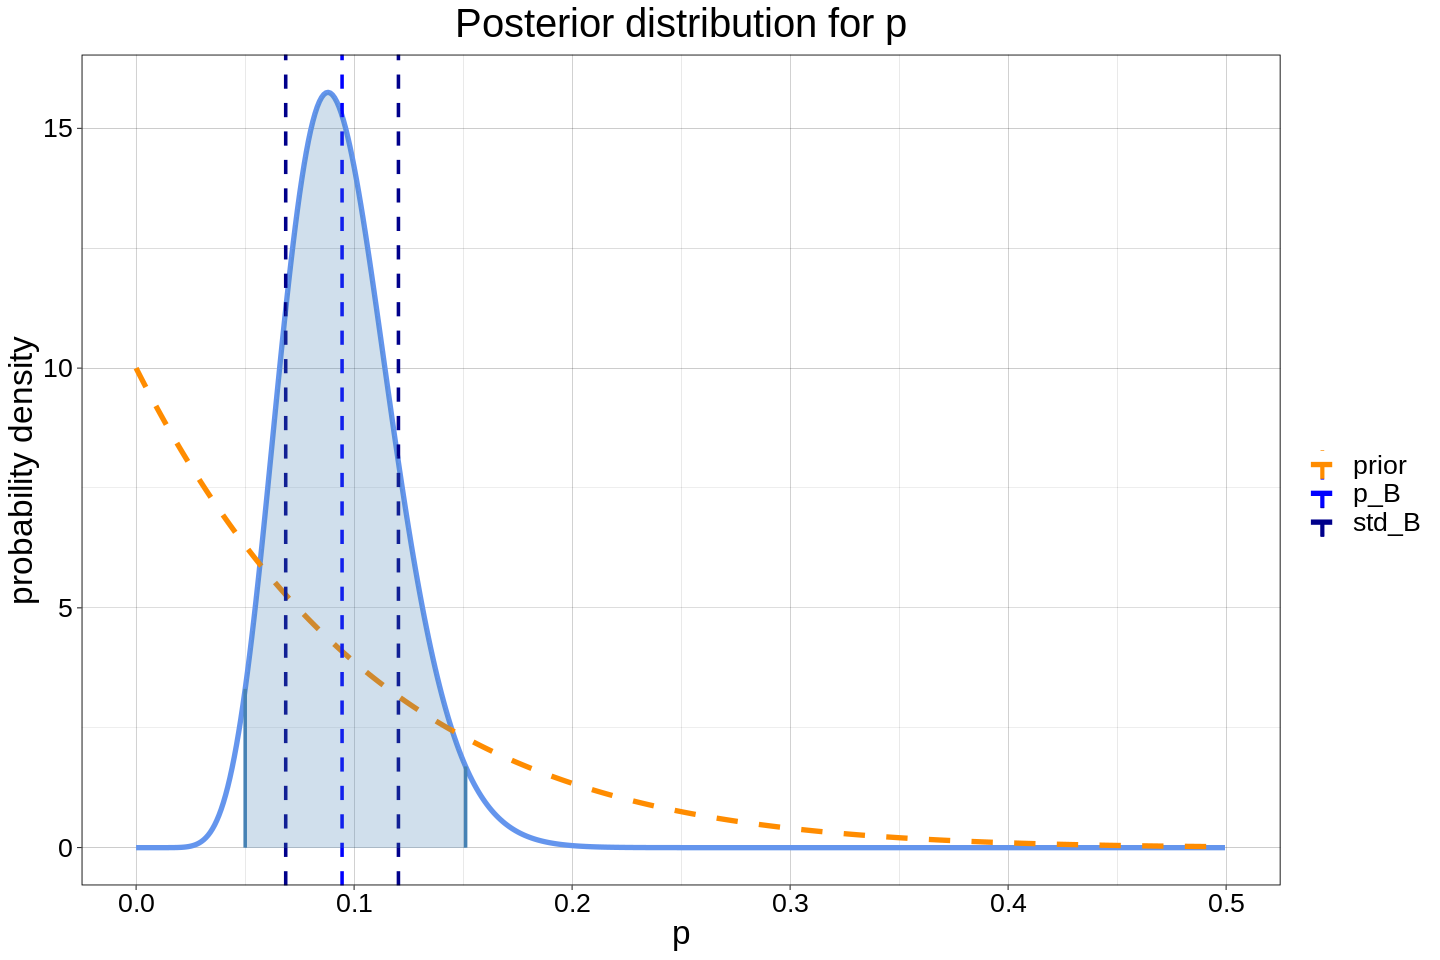

In [69]:
cols = c("prior"="darkorange", "p_B"="blue", "std_B"="blue4")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.5], y=beta_posterior[p<0.5]), color="cornflowerblue", lwd=1.5) + 
     geom_line(aes(x=p[p<0.5], y=beta_prior[p<0.5], color="prior"), linetype="dashed", lwd=1.5) +                                                            
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +

     # plot mean, med, std
     geom_vline(aes(xintercept=p_B, color="p_B"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=p_B-sqrt(var_B), color="std_B"), lwd=1, linetype="dashed") +
     geom_vline(aes(xintercept=p_B+sqrt(var_B), color="std_B"), lwd=1, linetype="dashed") +

     # plot 95% credibility intervals
     geom_ribbon(aes(x=p[which(between(p, post_low, post_high))], 
                     ymax=beta_posterior[which(between(p, post_low, post_high))], 
                     ymin=rep(0, n_points)[which(between(p, post_low, post_high))]),
                 fill="steelblue",
                 alpha=0.25) +  
     geom_segment(aes(x=post_high, xend=post_high, y=0, yend=beta_posterior[which(p>=post_high)][1]),
                  color="steelblue",
                  lwd=1) +
     geom_segment(aes(x=post_low, xend=post_low, y=0, yend=beta_posterior[which(p>=post_low)][1]),
                  color="steelblue",
                  lwd=1) +
     scale_color_manual(name="",
                         values=cols) +
     xlab("p") +
     xlim(c(0, 0.5))

plot_posterior

### Exercise 6
Redo this analysis with JAGS
Uniform prior
First of all we have to define the JAGS model:

        model{
            # data likelihood
            y ~ dbinom(p, n)

            # uniform prior for p
            p ~ dbeta(alpha, beta)
        }

In [70]:
# define model data
data       = NULL

data$alpha   = 1
data$beta    = 10
data$y = y
data$n = n

# define model
model_file   = "ex4.bug"
jagsModel    = jags.model(model_file, data)

# run for a burn in period
update(jagsModel, n.iter=1000)

# generate MCMC samples
chain = coda.samples(jagsModel, c("p"), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0952059      0.0261116      0.0002611      0.0003418 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05057 0.07667 0.09302 0.11120 0.15214 



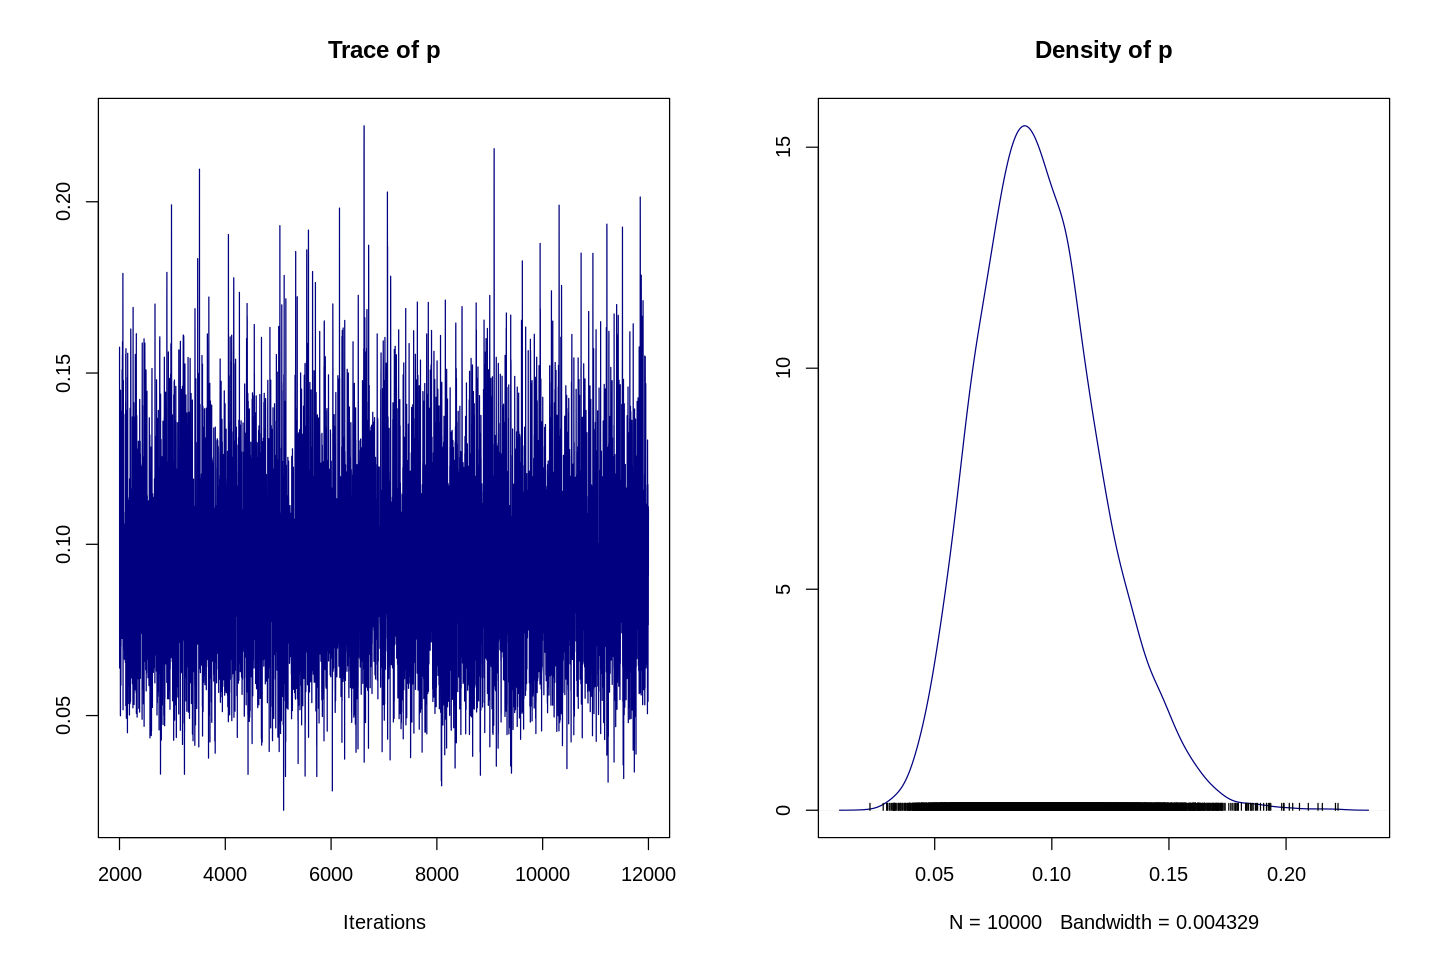

In [71]:
# plot final posterior
options(repr.plot.width=12, repr.plot.height=8)
plot(chain, col="navy")

In [72]:
cat("################################## analytical ##################################\n\n")
cat(" mean:", round(p_B, 4), "variance:", round(var_B, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(post_low, 3), "high:", round(post_high, 3)," \n")

mean_jags = unname(summary(chain)$statistics["Mean"])
std_jags  = unname(summary(chain)$statistics["SD"])
high_jags = unname(summary(chain)$quantiles["97.5%"])
low_jags = unname(summary(chain)$quantiles["2.5%"])

cat("####################################  jags  ####################################\n")
cat(" n1 \n")
cat(" mean:", round(mean_jags, 4), "variance:", round(std_jags^2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(low_jags, 3), "high:", round(high_jags, 3)," \n")

################################## analytical ##################################

 mean: 0.0945 variance: 7e-04
 Bounds for a 95% credibility interval:
	 low: 0.05 high: 0.151  
####################################  jags  ####################################
 n1 
 mean: 0.0952 variance: 7e-04
 Bounds for a 95% credibility interval:
	 low: 0.051 high: 0.152  


d) 
$$
H_0 : p = 0.1 \, \text{versus} \,  H_1 : p \neq 0.1
$$

In [56]:
p0 = 0.1
alpha = 0.05

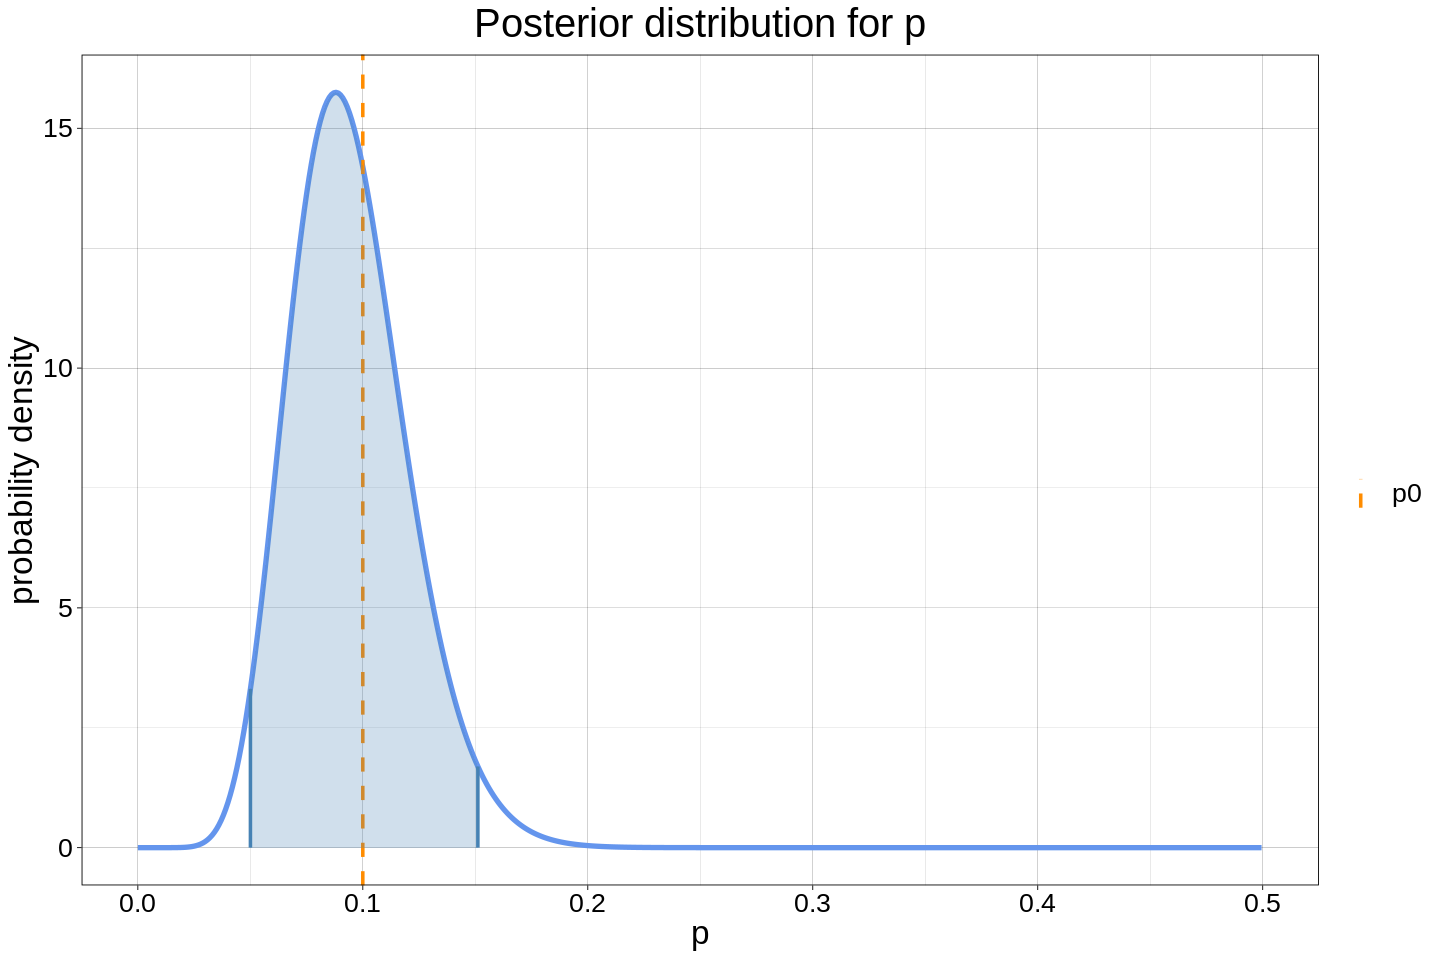

In [57]:
cols = c("p0"="darkorange")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.5], y=beta_posterior[p<0.5]), color="cornflowerblue", lwd=1.5) +                                                             
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +

     # plot p0
     geom_vline(aes(xintercept=p0, color="p0"), lwd=1, linetype="dashed") +

     # plot 95% credibility intervals
     geom_ribbon(aes(x=p[which(between(p, post_low, post_high))], 
                     ymax=beta_posterior[which(between(p, post_low, post_high))], 
                     ymin=rep(0, n_points)[which(between(p, post_low, post_high))]),
                 fill="steelblue",
                 alpha=0.25) +  
     geom_segment(aes(x=post_high, xend=post_high, y=0, yend=beta_posterior[which(p>=post_high)][1]),
                  color="steelblue",
                  lwd=1) +
     geom_segment(aes(x=post_low, xend=post_low, y=0, yend=beta_posterior[which(p>=post_low)][1]),
                  color="steelblue",
                  lwd=1) +
     scale_color_manual(name="",
                         values=cols) +
     xlab("p") +
     xlim(c(0, 0.5))

plot_posterior

In the bayesian approach we see that the $p_0$ is inside the credibility interval so we cannot reject the null hypotesis

In [58]:
y_list = seq(0, 25, 1)
p_y_np = dbinom(y_list, n, p0)

low = qbinom(0.025, n, p0)
high = qbinom(0.975, n, p0)

# alpha closest to 5% 
alpha = 1-(pbinom(high, n, p0)-pbinom(low-1, n, p0))
cat("the level of significant as close to 5% as possible is: y<", low, "or y>", high, "with alpha=", round(alpha, 3))

the level of significant as close to 5% as possible is: y< 6 or y> 18 with alpha= 0.043

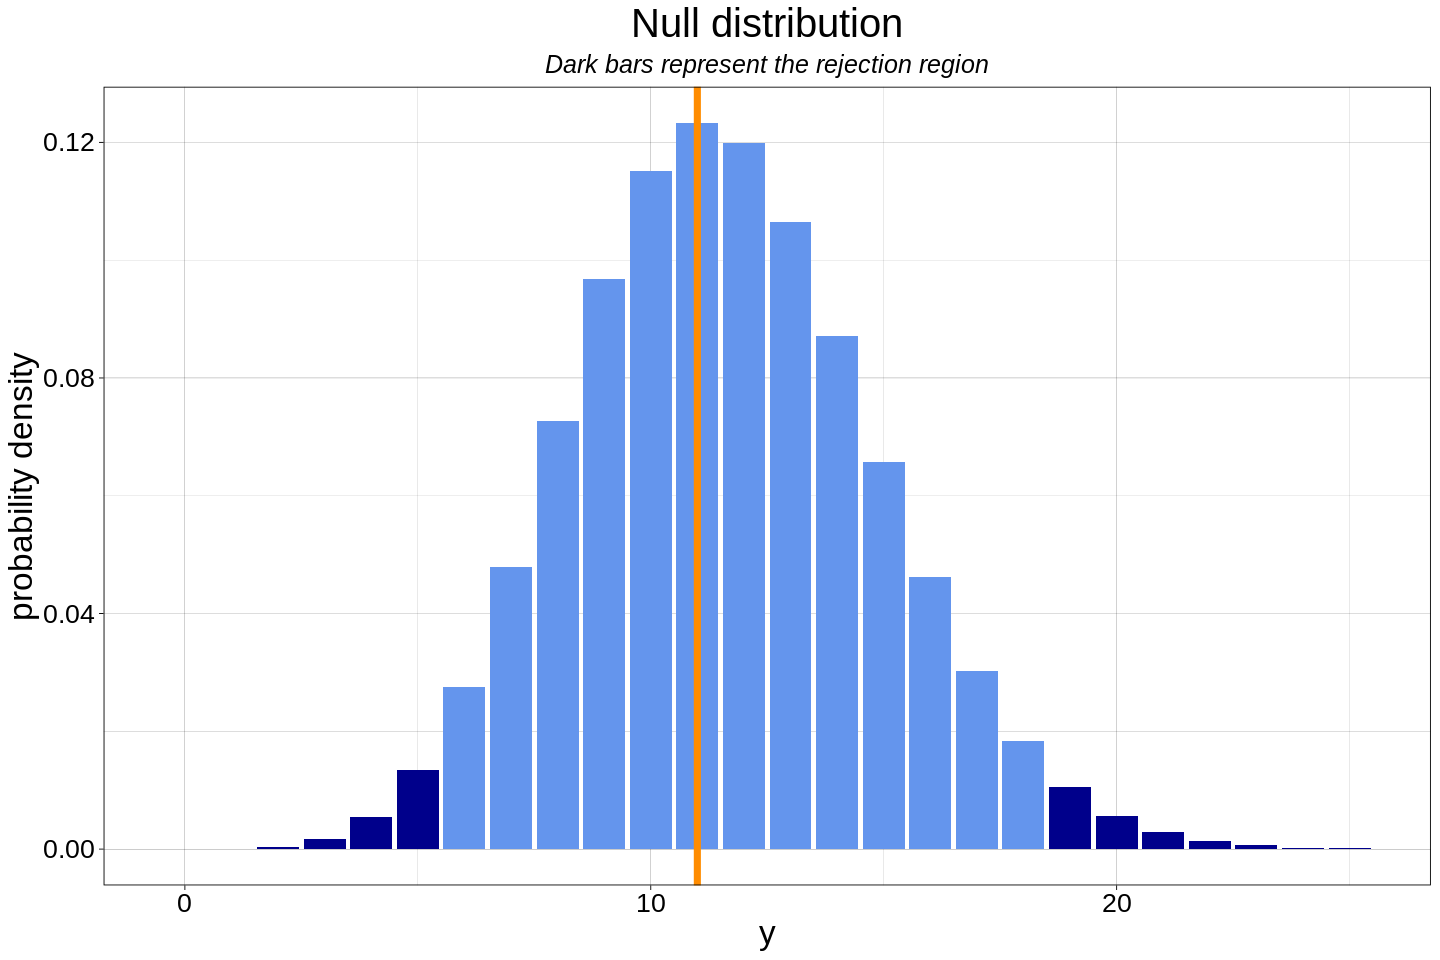

In [59]:
options(repr.plot.width=12, repr.plot.height=8) 
p = ggplot() +
    theme_linedraw() +
    theme(text=element_text(size=20), 
          plot.title=element_text(hjust = 0.5),
          plot.subtitle=element_text(hjust=0.5, size=15, face="italic")
          ) +
    ggtitle("Null distribution") +
    labs(subtitle="Dark bars represent the rejection region") +
    geom_bar(aes(x=y_list, y=p_y_np), 
             fill=ifelse(between(y_list, low, high), "cornflowerblue", "blue4"),
             stat="identity") +
    geom_vline(aes(xintercept=y), color="darkorange", lwd=2) +
    xlab("y") +
    ylab("probability density")
    
p

we observe that y=11 lies inside the acceptance region so we cannot reject the null hypotesis

e)


In [60]:
n = 165
y = 9

n_points = 1000
p = seq(0, 1, length.out = n_points)

# frequentist estimator
pf=y/n
cat("the frequentist estimator is", round(pf,3))

the frequentist estimator is 0.055

f) we call prior 1 the $\text{Beta}(1, 10)$, and prior 2 the previous posterior

In [61]:
# w prior 1 
alpha = 1
beta  = 10

alpha_p1 = alpha+y
beta_p1  = beta+n-y
beta_posterior = dbeta(p, alpha_p1, beta_p1)

# w prior 2
alpha_p2 = alpha_p+y
beta_p2  = beta_p+n-y
beta_posterior2 = dbeta(p, alpha_p2, beta_p2)

# w prior 1
p_B1   = alpha_p1/(alpha_p1+beta_p1)
var_B1 = alpha_p1*beta_p1/((alpha_p1+beta_p1)^2*(alpha_p1+beta_p1+1))
post_high1 = p[cumsum(beta_posterior/n_points)>0.975][1]
post_low1  = p[cumsum(beta_posterior/n_points)>0.025][1]
cat("###################################### prior 1 ######################################\n")
cat(" bayesian estimator =", round(p[which.max(beta_posterior)],3), "\n")
cat(" mean:", round(p_B1, 4), "variance:", round(var_B1, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(post_low1, 3), "high:", round(post_high1, 3)," \n")

# w prior 2
p_B2   = alpha_p2/(alpha_p2+beta_p2)
var_B2 = alpha_p2*beta_p2/((alpha_p2+beta_p2)^2*(alpha_p2+beta_p2+1))
post_high2 = p[cumsum(beta_posterior2/n_points)>0.975][1]
post_low2  = p[cumsum(beta_posterior2/n_points)>0.025][1]
cat("###################################### prior 2 ######################################\n")
cat(" bayesian estimator =", round(p[which.max(beta_posterior2)],3), "\n")
cat(" mean:", round(p_B2, 4), "variance:", round(var_B2, 4))
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", round(post_low2, 3), "high:", round(post_high2, 3)," \n")

###################################### prior 1 ######################################
 bayesian estimator = 0.052 
 mean: 0.0568 variance: 3e-04
 Bounds for a 95% credibility interval:
	 low: 0.028 high: 0.096  
###################################### prior 2 ######################################
 bayesian estimator = 0.069 
 mean: 0.0719 variance: 2e-04
 Bounds for a 95% credibility interval:
	 low: 0.045 high: 0.104  


h)

In [62]:
p0 = 0.1
alpha = 0.05

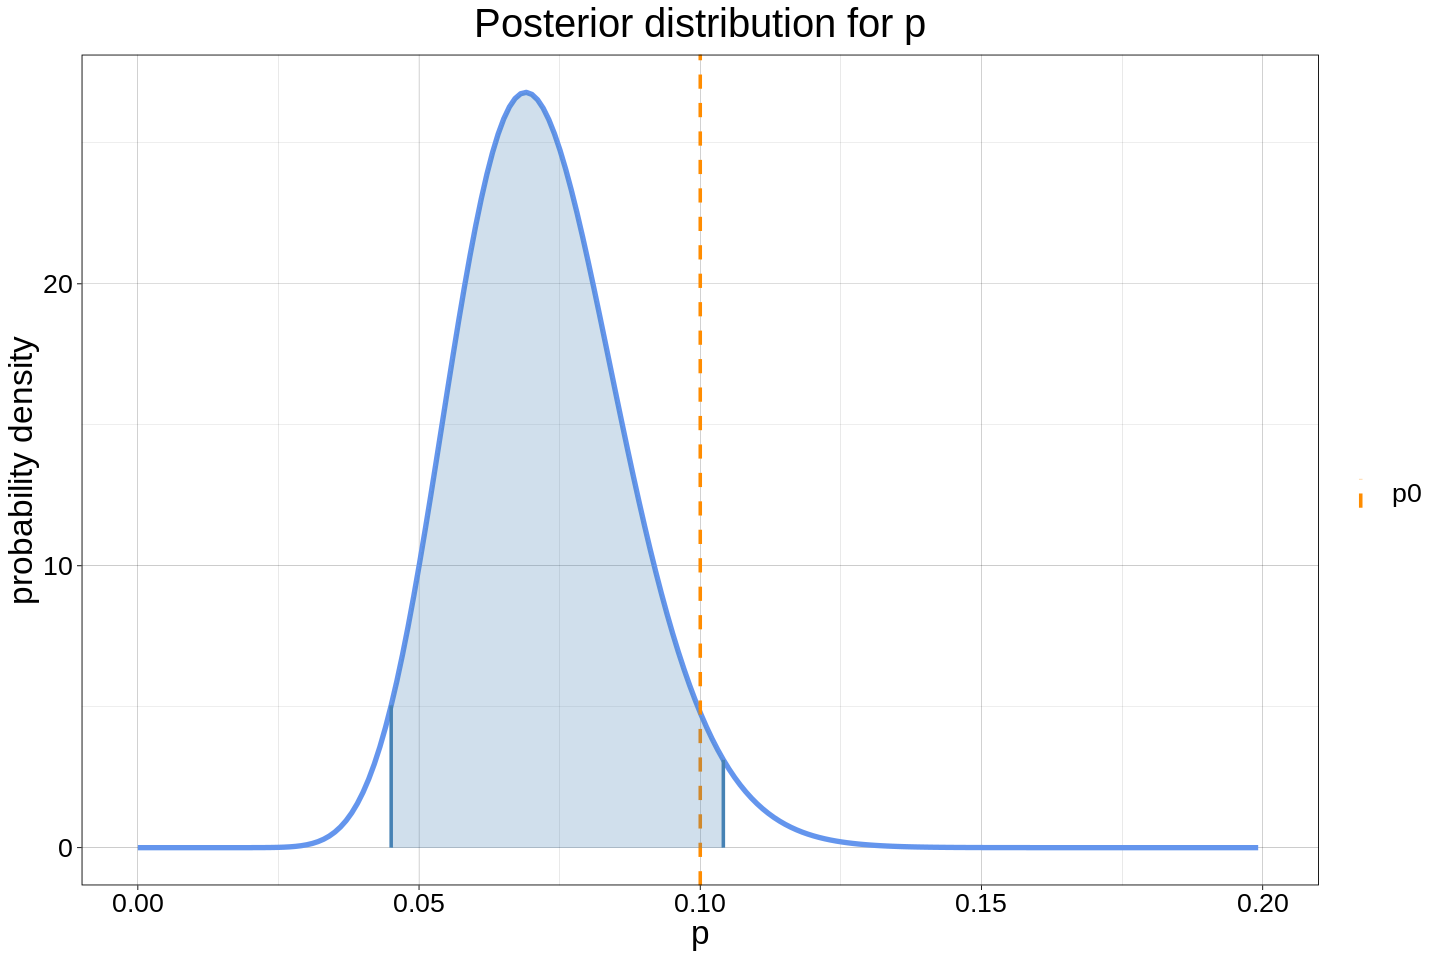

In [63]:
cols = c("p0"="darkorange")
options(repr.plot.width=12, repr.plot.height=8) 
plot_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=p[p<0.2], y=beta_posterior2[p<0.2]), color="cornflowerblue", lwd=1.5) +                                                             
     theme(text = element_text(size=20)) +
     ggtitle("Posterior distribution for p") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("probability density") +

     # plot p0
     geom_vline(aes(xintercept=p0, color="p0"), lwd=1, linetype="dashed") +

     # plot 95% credibility intervals
     geom_ribbon(aes(x=p[which(between(p, post_low2, post_high2))], 
                     ymax=beta_posterior2[which(between(p, post_low2, post_high2))], 
                     ymin=rep(0, n_points)[which(between(p, post_low2, post_high2))]),
                 fill="steelblue",
                 alpha=0.25) +  
     geom_segment(aes(x=post_high2, xend=post_high2, y=0, yend=beta_posterior2[which(p>=post_high2)][1]),
                  color="steelblue",
                  lwd=1) +
     geom_segment(aes(x=post_low2, xend=post_low2, y=0, yend=beta_posterior2[which(p>=post_low2)][1]),
                  color="steelblue",
                  lwd=1) +
     scale_color_manual(name="",
                         values=cols) +
     xlab("p") +
     xlim(c(0, 0.2))

plot_posterior

again, we cannot reject the null hypotesis

In [64]:
y_list = seq(0, 30, 1)
p_y_np = dbinom(y_list, n, p0)

low = qbinom(0.025, n, p0)
high = qbinom(0.975, n, p0)

# alpha closest to 5% 
alpha = 1-(pbinom(high, n, p0)-pbinom(low, n, p0))
cat("the level of significant as close to 5% as possible is: y<=", low, "or y>", high, "with alpha=", round(alpha, 3))

the level of significant as close to 5% as possible is: y<= 9 or y> 24 with alpha= 0.051

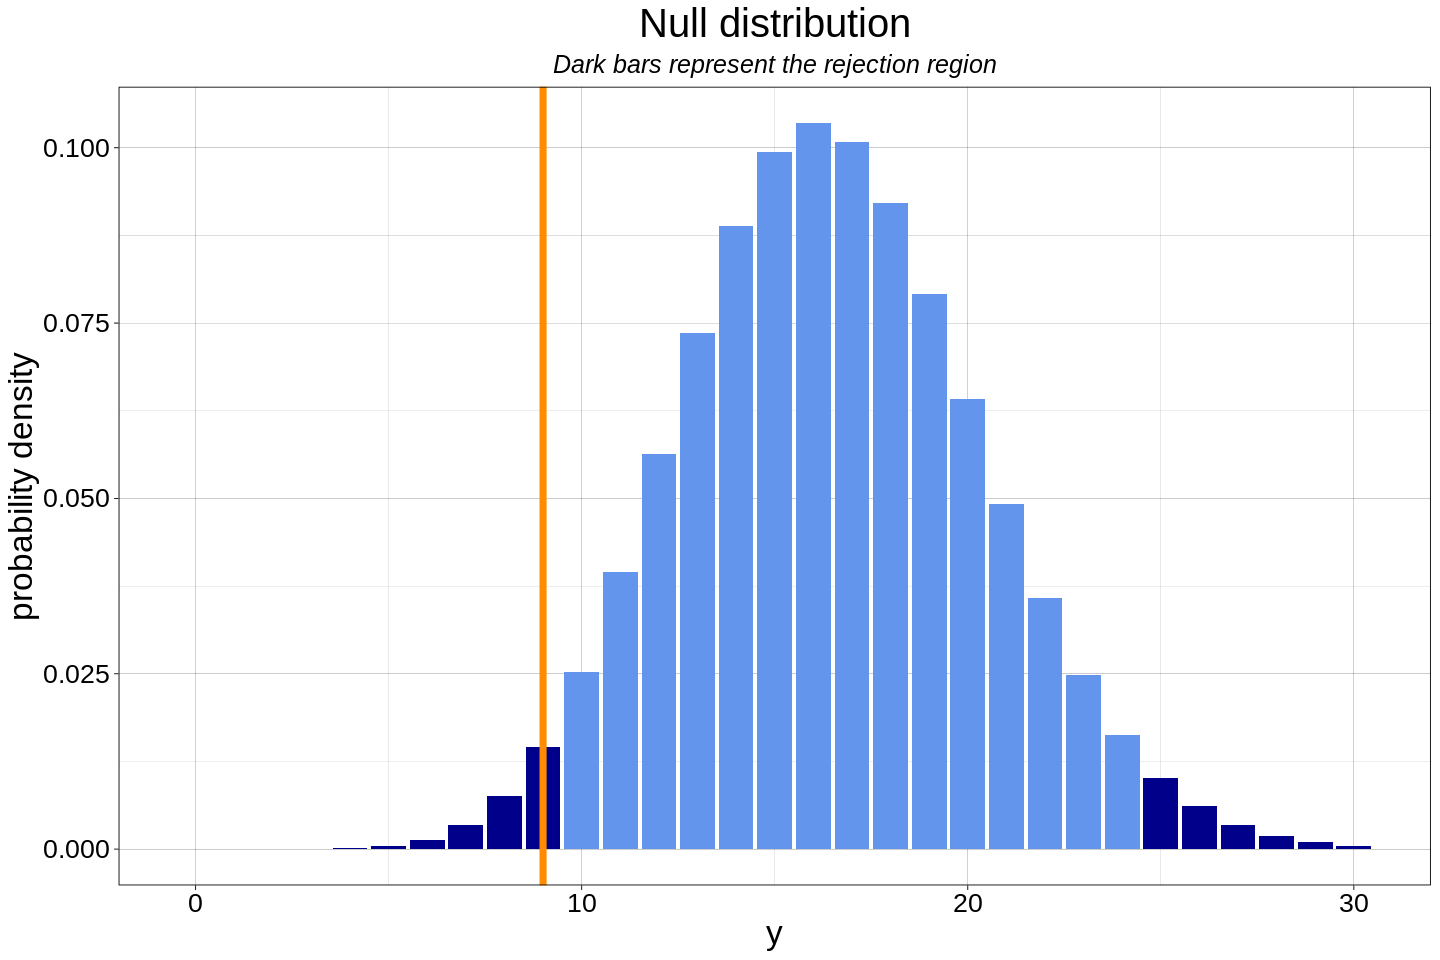

In [65]:
options(repr.plot.width=12, repr.plot.height=8) 
p = ggplot() +
    theme_linedraw() +
    theme(text=element_text(size=20), 
          plot.title=element_text(hjust = 0.5),
          plot.subtitle=element_text(hjust=0.5, size=15, face="italic")
          ) +
    ggtitle("Null distribution") +
    labs(subtitle="Dark bars represent the rejection region") +
    geom_bar(aes(x=y_list, y=p_y_np), 
             fill=ifelse(between(y_list, low+1, high), "cornflowerblue", "blue4"),
             stat="identity") +
    geom_vline(aes(xintercept=y), color="darkorange", lwd=2) +
    xlab("y") +
    ylab("probability density")
    
p

in this case we are right at the boundary and we have to reject the null hypotesis